In [1]:
import random 
import warnings
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
VAR_SEED = 42
VAR_TESTSET_SIZE = 0.20
VAR_DIR_DATA_CLEANING = '../data/cleaning'

random.seed(VAR_SEED)
np.random.seed(VAR_SEED)
warnings.filterwarnings("ignore")

EJERCICIOS = pd.read_csv(f"{VAR_DIR_DATA_CLEANING}/ejercicios.csv", encoding="latin1")
ESTUDIANTES = pd.read_csv(f"{VAR_DIR_DATA_CLEANING}/estudiantes.csv", encoding="latin1")

REPROBADOS = ESTUDIANTES.query("`solemne_1` < 4.0 and `solemne_2` < 4.0 and `solemne_3` < 4.0 and `solemne_4` < 4.0")
APROBADOS = ESTUDIANTES[~ESTUDIANTES['id_estudiante'].isin(REPROBADOS['id_estudiante'])]

In [3]:
n_ejercicios = len(EJERCICIOS)
COLUMNAS_EJERCICIOS = [f"e{index}" for index in range(n_ejercicios)]
popularidad_items = APROBADOS[COLUMNAS_EJERCICIOS].iloc[:, :].sum(axis=0).to_dict()
popularidad_items = {int(key.replace('e', '')): value for key, value in popularidad_items.items()}

print(popularidad_items)

{0: 603, 1: 275, 2: 17, 3: 542, 4: 733, 5: 0, 6: 277, 7: 195, 8: 21, 9: 42, 10: 599, 11: 38, 12: 69, 13: 233, 14: 0, 15: 0, 16: 0, 17: 737, 18: 389, 19: 0, 20: 0, 21: 37, 22: 650, 23: 590, 24: 0, 25: 730, 26: 678, 27: 0, 28: 168, 29: 653, 30: 0, 31: 4, 32: 395, 33: 11, 34: 0, 35: 347, 36: 0, 37: 184, 38: 87, 39: 0, 40: 0, 41: 0, 42: 472, 43: 0, 44: 314, 45: 0, 46: 0, 47: 0, 48: 4, 49: 0, 50: 0, 51: 0, 52: 0}


In [4]:
df_items = EJERCICIOS[['id_ejercicio','h1','h2','h3','h4','s1','s2','s3','s4','k1','k2','k3','k4']]
df_users = APROBADOS[['id_estudiante','programa','exitosos','fallidos','score_a','score_p','score_d','score_s'] + COLUMNAS_EJERCICIOS]

# División inicial en train y test
train_data, test_data = train_test_split(df_users, test_size=VAR_TESTSET_SIZE, random_state=VAR_SEED)
# División adicional en train y validation
train_data, validation_data = train_test_split(train_data, test_size=VAR_TESTSET_SIZE, random_state=VAR_SEED)

In [5]:
# Crear escalador
scaler = MinMaxScaler()
# Columnas a normalizar
columns_to_normalize = ['exitosos', 'fallidos', 'score_a', 'score_p', 'score_d', 'score_s']
# Ajustar el escalador en el conjunto de entrenamiento
scaler.fit(train_data[columns_to_normalize])  # Ajustar el escalador
# Normalización
train_data[columns_to_normalize] = scaler.transform(train_data[columns_to_normalize])
validation_data[columns_to_normalize] = scaler.transform(validation_data[columns_to_normalize])
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

In [6]:
validation_data.head()

,id_estudiante,programa,exitosos,fallidos,score_a,score_p,score_d,score_s,e0,e1,...,e43,e44,e45,e46,e47,e48,e49,e50,e51,e52
140,156,INGENIERIA EN COMPUTACION E INFORMATICA,0.480769,0.325,0.142857,0.0,0.50,0.25,1,1,...,0,1,0,0,0,0,0,0,0,0
1091,1305,INGENIERIA EN COMPUTACION E INFORMATICA,0.019231,0.725,0.000000,0.2,0.25,0.25,0,0,...,0,0,0,0,0,0,0,0,0,0
932,1123,INGENIERIA CIVIL INDUSTRIAL,0.096154,0.250,0.000000,0.2,0.25,0.25,0,0,...,0,0,0,0,0,0,0,0,0,0
331,369,INGENIERIA CIVIL INDUSTRIAL,0.269231,0.400,0.285714,0.6,0.25,0.50,1,1,...,0,1,0,0,0,0,0,0,0,0
25,28,INGENIERIA EN COMPUTACION E INFORMATICA,0.096154,0.250,0.285714,0.2,0.25,0.50,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# One-Hot Encoding para la variable 'programa'
# Obtener todas las categorías del conjunto de entrenamiento
all_categories = pd.get_dummies(train_data['programa'], drop_first=False).columns

# Generar dummies en cada conjunto y convertirlas a int
train_program_dummies = pd.get_dummies(train_data['programa'], drop_first=False).reindex(columns=all_categories, fill_value=0).astype(int)
validation_program_dummies = pd.get_dummies(validation_data['programa'], drop_first=False).reindex(columns=all_categories, fill_value=0).astype(int)
test_program_dummies = pd.get_dummies(test_data['programa'], drop_first=False).reindex(columns=all_categories, fill_value=0).astype(int)

# Reemplazar la columna original 'programa' con las nuevas columnas
train_data = train_data.drop(columns=['programa']).join(train_program_dummies)
validation_data = validation_data.drop(columns=['programa']).join(validation_program_dummies)
test_data = test_data.drop(columns=['programa']).join(test_program_dummies)

In [8]:
validation_data.head()

,id_estudiante,exitosos,fallidos,score_a,score_p,score_d,score_s,e0,e1,e2,...,e48,e49,e50,e51,e52,BACHILLERATO EN CIENCIAS,INGENIERIA CIVIL INDUSTRIAL,INGENIERIA CIVIL INFORMATICA,INGENIERIA EN COMPUTACION E INFORMATICA,INGENIERIA INDUSTRIAL
140,156,0.480769,0.325,0.142857,0.0,0.50,0.25,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1091,1305,0.019231,0.725,0.000000,0.2,0.25,0.25,0,0,0,...,0,0,0,0,0,0,0,0,1,0
932,1123,0.096154,0.250,0.000000,0.2,0.25,0.25,0,0,0,...,0,0,0,0,0,0,1,0,0,0
331,369,0.269231,0.400,0.285714,0.6,0.25,0.50,1,1,0,...,0,0,0,0,0,0,1,0,0,0
25,28,0.096154,0.250,0.285714,0.2,0.25,0.50,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
df_test_interacciones = test_data[['id_estudiante'] + COLUMNAS_EJERCICIOS]
df_train_interacciones = train_data[['id_estudiante'] + COLUMNAS_EJERCICIOS]
df_validation_interacciones = validation_data[['id_estudiante'] + COLUMNAS_EJERCICIOS]

df_test_interacciones.head()

,id_estudiante,e0,e1,e2,e3,e4,e5,e6,e7,e8,...,e43,e44,e45,e46,e47,e48,e49,e50,e51,e52
754,926,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,1184,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
353,391,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,1083,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,375,1,0,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [10]:
df_test_users = test_data.drop(columns=COLUMNAS_EJERCICIOS)
df_train_users = train_data.drop(columns=COLUMNAS_EJERCICIOS)
df_validation_users = validation_data.drop(columns=COLUMNAS_EJERCICIOS)

df_test_users.head()

,id_estudiante,exitosos,fallidos,score_a,score_p,score_d,score_s,BACHILLERATO EN CIENCIAS,INGENIERIA CIVIL INDUSTRIAL,INGENIERIA CIVIL INFORMATICA,INGENIERIA EN COMPUTACION E INFORMATICA,INGENIERIA INDUSTRIAL
754,926,0.038462,0.325,0.000000,0.2,0.25,0.25,0,1,0,0,0
985,1184,0.288462,0.000,0.000000,0.2,0.25,0.25,0,0,1,0,0
353,391,0.269231,0.600,0.428571,0.6,0.75,0.75,0,0,1,0,0
897,1083,0.269231,0.400,0.000000,0.2,0.25,0.25,0,0,1,0,0
337,375,0.346154,0.300,0.857143,0.8,1.00,0.75,0,0,0,0,1


In [11]:
class TwoTowerRecommenderSystem:

    def __init__(self, Two_Tower_Model, User_Tower, Item_Tower, 
                 user_input_size: int, item_input_size: int,
                 embedding_size: int = 64, dropout_rate: float = 0.5, learning_rate: float = 0.001, weight_decay: float = 1e-4, 
                 optimizer_system=optim.Adam, criterion_system=nn.BCELoss):
        
        self.model = Two_Tower_Model(user_input_size, item_input_size, embedding_size, dropout_rate, User_Tower, Item_Tower)
        self.optimizer = optimizer_system(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.criterion = criterion_system()


    def save_model(self, file_path: str) -> None:
        torch.save(self.model.state_dict(), file_path)
        print(f"[+] Modelo guardado en {file_path}")


    def load_model(self, file_path: str) -> None:
        self.model.load_state_dict(torch.load(file_path))
        self.model.eval()
        print(f"[+] Modelo cargado desde {file_path}")


    def load_data_train(self, data_items: DataFrame, data_users: DataFrame, data_interactions: DataFrame) -> None:
        self.items_inputs = torch.tensor(data_items.iloc[:, 1:].values).float()
        self.users_inputs = torch.tensor(data_users.iloc[:, 1:].values).float()
        self.interactions_inputs = torch.tensor(data_interactions.iloc[:, 1:].values).float()
        print(f"[+] Ítems cargados: {self.items_inputs.size(0)} ítems con {self.items_inputs.size(1)} características cada uno.")
        print(f"[+] Users cargados: {self.users_inputs.size(0)} users con {self.users_inputs.size(1)} características cada uno.")
        print(f"[+] Interactions cargados: {self.interactions_inputs.size(0)} interactions con {self.interactions_inputs.size(1)} características cada uno.")


    def train(self, epochs: int = 30) -> list:
        if self.items_inputs is None or self.users_inputs is None or self.interactions_inputs is None:
            raise ValueError("[-] No se cargaron datos de entrenamiento. Usa load_data_train() primero.")
        # Dimensiones de entrada
        num_users = self.users_inputs.size(0)           # Número de usuarios (n)
        num_items = self.items_inputs.size(0)           # Número de ítems (k)
        # Expandir datos de usuario e ítem para todas las combinaciones usuario-ítem
        user_input_expanded = self.users_inputs.unsqueeze(1).expand(-1, num_items, -1).reshape(-1, self.users_inputs.size(1))   # (n * k, m)
        item_input_expanded = self.items_inputs.repeat(num_users, 1)                                                            # (n * k, h)
        # Aplanar las etiquetas de interacciones para todas las combinaciones usuario-ítem
        labels = self.interactions_inputs.flatten()                                                                             # Tensor de tamaño (n * k)
        # Verificar dimensiones
        assert user_input_expanded.size(0) == item_input_expanded.size(0) == labels.size(0), \
            f"[-] Dimensiones incompatibles: user_input_expanded={user_input_expanded.size(0)}, " \
            f"[-] item_input_expanded={item_input_expanded.size(0)}, labels={labels.size(0)}"
        # Lista para almacenar las pérdidas
        losses = []
        # Proceso de entrenamiento
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            output = self.model(user_input_expanded, item_input_expanded)
            loss = self.criterion(output, labels)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            print(f"[+] Epoch {epoch + 1}/{epochs} => Loss: {loss.item():.4f}")
        # Valores de perdida de la función
        return losses


    def precision_at_k(self, true_labels, pred_scores, k):
        _, top_k_indices = torch.topk(pred_scores, k)                       # Índices de los top-k ítems predichos
        top_k_pred = torch.zeros_like(true_labels)                          # Inicializar predicciones binarias
        top_k_pred[top_k_indices] = 1                                       # Marcar los top-k como predichos
        num_true_positives = torch.sum(top_k_pred * true_labels).item()     # Ítems relevantes en top-k
        precision = num_true_positives / k                                  # Precisión
        return precision


    def recall_at_k(self, true_labels, pred_scores, k):
        _, top_k_indices = torch.topk(pred_scores, k)                       # Índices de los top-k ítems predichos
        top_k_pred = torch.zeros_like(true_labels)                          # Inicializar predicciones binarias
        top_k_pred[top_k_indices] = 1                                       # Marcar los top-k como predichos
        num_true_positives = torch.sum(top_k_pred * true_labels).item()     # Ítems relevantes en top-k
        num_relevant_items = torch.sum(true_labels).item()                  # Ítems relevantes reales
        recall = num_true_positives / num_relevant_items if num_relevant_items > 0 else 0
        return recall


    def ndcg_at_k(self, true_labels, pred_scores, k):
        _, top_k_indices = torch.topk(pred_scores, k)                                                       # Índices de los top-k ítems predichos
        ideal_sorted_labels = torch.sort(true_labels, descending=True)[0][:k]                               # Relevancias ideales ordenadas        
        dcg = torch.sum(true_labels[top_k_indices] / torch.log2(torch.arange(2, k + 2).float())).item()     # DCG (Discounted Cumulative Gain)
        ideal_dcg = torch.sum(ideal_sorted_labels / torch.log2(torch.arange(2, k + 2).float())).item()      # IDCG (Ideal Discounted Cumulative Gain)
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
        return ndcg


    def evaluate(self, val_users: DataFrame, val_interactions: DataFrame, k: int = 10) -> None:
        # Convertir datos a tensores
        user_inputs = torch.tensor(val_users.iloc[:, 1:].values).float()
        interactions = torch.tensor(val_interactions.iloc[:, 1:].values).float()
        # Dimensiones
        num_items = self.items_inputs.size(0)
        num_users = user_inputs.size(0)
        # Expandir para todas las combinaciones usuario-ítem
        user_input_expanded = user_inputs.unsqueeze(1).expand(-1, num_items, -1).reshape(-1, user_inputs.size(1))
        item_input_expanded = self.items_inputs.repeat(num_users, 1)
        # Etiquetas reales
        labels = interactions
        # Predicciones del modelo
        self.model.eval()
        with torch.no_grad():
            output = self.model(user_input_expanded, item_input_expanded).reshape(num_users, num_items)  
        # Calcular métricas
        precisions, recalls, ndcgs = [], [], []
        for user_idx in range(num_users):
            true_labels = labels[user_idx]
            pred_scores = output[user_idx]
            precisions.append(self.precision_at_k(true_labels, pred_scores, k))
            recalls.append(self.recall_at_k(true_labels, pred_scores, k))
            ndcgs.append(self.ndcg_at_k(true_labels, pred_scores, k))
        # Promediar métricas
        mean_precision = sum(precisions) / num_users
        mean_recall = sum(recalls) / num_users
        mean_ndcg = sum(ndcgs) / num_users
        print(f"[+] Evaluation Results => Precision@{k}: {mean_precision:.4f}, Recall@{k}: {mean_recall:.4f}, NDCG@{k}: {mean_ndcg:.4f}")


    def recommend(self, user_features: DataFrame, interacted_items: list[int], top_k: int = 10) -> list[tuple]:
        if self.items_inputs is None:
            raise ValueError("[-] No se cargaron datos de entrenamiento. Usa load_data_train() primero.")

        user_features = torch.tensor(user_features.iloc[:, 1:].values).float()

        self.model.eval()
        with torch.no_grad():
            user_embedding = self.model.user_tower(user_features.unsqueeze(0))                      # Generar embedding del usuario     # (1, embedding_size)
            item_embeddings = self.model.item_tower(self.items_inputs)                              # Generar embeddings de los ítems   # (num_items, embedding_size)
            scores = torch.matmul(item_embeddings, user_embedding.squeeze().unsqueeze(1)).squeeze() # Calcular los scores
            
            if not interacted_items: # Validar `interacted_items`
                print("[-] Warning: La lista interacted_items está vacía.")
            else:
                for idx in interacted_items:
                    if idx < 0 or idx >= len(scores):
                        raise ValueError(f"Índice fuera de rango: {idx}")

            for idx in interacted_items:                                                                                # Penalizar ítems ya interactuados
                scores[idx] = float('-inf')                                                                             # Penalizar ítems interactuados con -inf

            top_k_scores, top_k_indices = torch.topk(scores, top_k)                                                     # Obtener los top-k ítems
            recommendations = [ (idx, score) for idx, score in zip(top_k_indices.tolist(), top_k_scores.tolist()) ]     # Generar recomendaciones
            return recommendations


    def evaluate_relevance(self, recommended_items: dict[int, list[int]], popularity_bias: dict[int, int]) -> None:
        # Coverage
        unique_items = set(item for items in recommended_items.values() for item in items)
        coverage = len(unique_items) / self.items_inputs.shape[0]

        # Novelty
        min_popularity = 1 / (sum(popularity_bias.values()) + 1)  # Calcular un valor mínimo positivo para ítems sin interacciones (Evita división por cero)
        novelty = 0
        total_recommendations = 0
        for items in recommended_items.values():
            for item in items:  # Obtener la popularidad del ítem, usando el mínimo si no tiene interacciones
                item_popularity = max(popularity_bias.get(item, 0), min_popularity)
                novelty += -torch.log2(torch.tensor(item_popularity))
                total_recommendations += 1
        novelty /= total_recommendations

        # Popularity Bias
        avg_popularity = 0
        for items in recommended_items.values():
            avg_popularity += sum(popularity_bias.get(item, 0) for item in items)
        avg_popularity /= total_recommendations

        # Imprimir métricas
        print(f"Convergencia: {coverage:.4f}, Novedad: {novelty:.4f}, Sesgo de Popularidad: {avg_popularity:.4f}")


In [12]:
from utils.config_torres import *

In [13]:
#  ████████╗██╗    ██╗ ██████╗ ████████╗ ██████╗ ██╗    ██╗███████╗██████╗ ███╗   ███╗ ██████╗ ██████╗ ███████╗██╗     
#  ╚══██╔══╝██║    ██║██╔═══██╗╚══██╔══╝██╔═══██╗██║    ██║██╔════╝██╔══██╗████╗ ████║██╔═══██╗██╔══██╗██╔════╝██║     
#     ██║   ██║ █╗ ██║██║   ██║   ██║   ██║   ██║██║ █╗ ██║█████╗  ██████╔╝██╔████╔██║██║   ██║██║  ██║█████╗  ██║     
#     ██║   ██║███╗██║██║   ██║   ██║   ██║   ██║██║███╗██║██╔══╝  ██╔══██╗██║╚██╔╝██║██║   ██║██║  ██║██╔══╝  ██║     
#     ██║   ╚███╔███╔╝╚██████╔╝   ██║   ╚██████╔╝╚███╔███╔╝███████╗██║  ██║██║ ╚═╝ ██║╚██████╔╝██████╔╝███████╗███████╗
#     ╚═╝    ╚══╝╚══╝  ╚═════╝    ╚═╝    ╚═════╝  ╚══╝╚══╝ ╚══════╝╚═╝  ╚═╝╚═╝     ╚═╝ ╚═════╝ ╚═════╝ ╚══════╝╚══════╝


# V1
recomendador_v1_1 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModel, 
    User_Tower=UserTowerV1,
    Item_Tower=ItemTowerV1,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v1_1.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v1_1 = recomendador_v1_1.train()


# V2
recomendador_v1_2 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModel, 
    User_Tower=UserTowerV2,
    Item_Tower=ItemTowerV2,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v1_2.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v1_2 = recomendador_v1_2.train()


# V3
recomendador_v1_3 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModel, 
    User_Tower=UserTowerV3,
    Item_Tower=ItemTowerV3,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v1_3.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v1_3 = recomendador_v1_3.train()

[+] Ítems cargados: 53 ítems con 12 características cada uno.
[+] Users cargados: 489 users con 11 características cada uno.
[+] Interactions cargados: 489 interactions con 53 características cada uno.
[+] Epoch 1/30 => Loss: 0.7213
[+] Epoch 2/30 => Loss: 0.6466
[+] Epoch 3/30 => Loss: 0.5939
[+] Epoch 4/30 => Loss: 0.5542
[+] Epoch 5/30 => Loss: 0.5262
[+] Epoch 6/30 => Loss: 0.5078
[+] Epoch 7/30 => Loss: 0.4995
[+] Epoch 8/30 => Loss: 0.4930
[+] Epoch 9/30 => Loss: 0.4847
[+] Epoch 10/30 => Loss: 0.4804
[+] Epoch 11/30 => Loss: 0.4688
[+] Epoch 12/30 => Loss: 0.4534
[+] Epoch 13/30 => Loss: 0.4413
[+] Epoch 14/30 => Loss: 0.4258
[+] Epoch 15/30 => Loss: 0.4130
[+] Epoch 16/30 => Loss: 0.4002
[+] Epoch 17/30 => Loss: 0.3915
[+] Epoch 18/30 => Loss: 0.3819
[+] Epoch 19/30 => Loss: 0.3756
[+] Epoch 20/30 => Loss: 0.3702
[+] Epoch 21/30 => Loss: 0.3629
[+] Epoch 22/30 => Loss: 0.3589
[+] Epoch 23/30 => Loss: 0.3508
[+] Epoch 24/30 => Loss: 0.3478
[+] Epoch 25/30 => Loss: 0.3421
[+] Epo

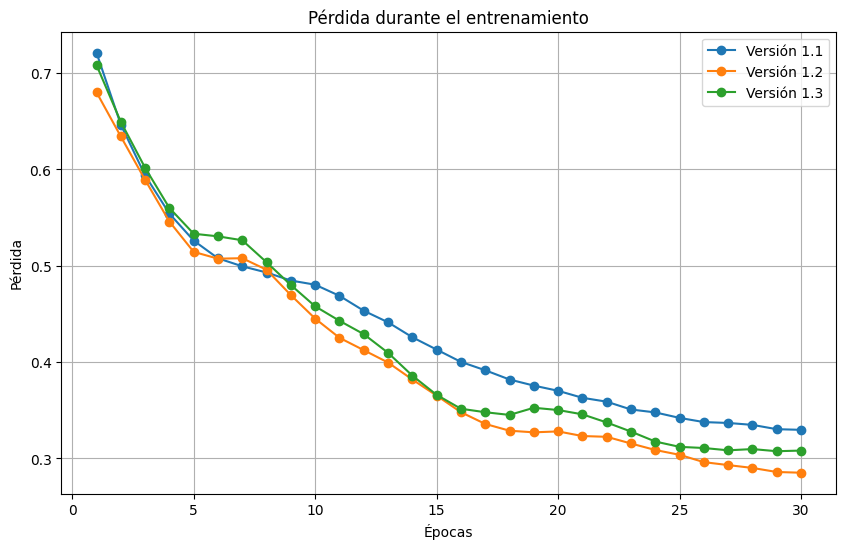

In [14]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_v1_1) + 1), loss_v1_1, marker='o', linestyle='-', label='Versión 1.1')
plt.plot(range(1, len(loss_v1_2) + 1), loss_v1_2, marker='o', linestyle='-', label='Versión 1.2')
plt.plot(range(1, len(loss_v1_3) + 1), loss_v1_3, marker='o', linestyle='-', label='Versión 1.3')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()

# Añadir leyenda
plt.legend(loc='best')  # Ajusta automáticamente la posición de la leyenda

# Mostrar el gráfico
plt.show()

In [15]:
recomendador_v1_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v1_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v1_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
print()
recomendador_v1_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v1_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v1_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
print()
recomendador_v1_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v1_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v1_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)

[+] Evaluation Results => Precision@5: 0.6878, Recall@5: 0.2609, NDCG@5: 0.7130
[+] Evaluation Results => Precision@5: 0.7577, Recall@5: 0.3504, NDCG@5: 0.7732
[+] Evaluation Results => Precision@5: 0.7041, Recall@5: 0.2957, NDCG@5: 0.7426

[+] Evaluation Results => Precision@10: 0.6789, Recall@10: 0.5562, NDCG@10: 0.6966
[+] Evaluation Results => Precision@10: 0.7154, Recall@10: 0.6053, NDCG@10: 0.8010
[+] Evaluation Results => Precision@10: 0.6894, Recall@10: 0.5655, NDCG@10: 0.7514

[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7377
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.8274
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7812


In [16]:
#  ████████╗██╗    ██╗ ██████╗ ████████╗ ██████╗ ██╗    ██╗███████╗██████╗ ███╗   ███╗ ██████╗ ██████╗ ███████╗██╗    ██╗   ██╗ ██╗
#  ╚══██╔══╝██║    ██║██╔═══██╗╚══██╔══╝██╔═══██╗██║    ██║██╔════╝██╔══██╗████╗ ████║██╔═══██╗██╔══██╗██╔════╝██║    ██║   ██║███║
#     ██║   ██║ █╗ ██║██║   ██║   ██║   ██║   ██║██║ █╗ ██║█████╗  ██████╔╝██╔████╔██║██║   ██║██║  ██║█████╗  ██║    ██║   ██║╚██║
#     ██║   ██║███╗██║██║   ██║   ██║   ██║   ██║██║███╗██║██╔══╝  ██╔══██╗██║╚██╔╝██║██║   ██║██║  ██║██╔══╝  ██║    ╚██╗ ██╔╝ ██║
#     ██║   ╚███╔███╔╝╚██████╔╝   ██║   ╚██████╔╝╚███╔███╔╝███████╗██║  ██║██║ ╚═╝ ██║╚██████╔╝██████╔╝███████╗███████╗╚████╔╝  ██║
#     ╚═╝    ╚══╝╚══╝  ╚═════╝    ╚═╝    ╚═════╝  ╚══╝╚══╝ ╚══════╝╚═╝  ╚═╝╚═╝     ╚═╝ ╚═════╝ ╚═════╝ ╚══════╝╚══════╝ ╚═══╝   ╚═╝

# V1
recomendador_v2_1 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModelV1, 
    User_Tower=UserTowerV1,
    Item_Tower=ItemTowerV1,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v2_1.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v2_1 = recomendador_v2_1.train()


# V2
recomendador_v2_2 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModelV1, 
    User_Tower=UserTowerV2,
    Item_Tower=ItemTowerV2,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v2_2.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v2_2 = recomendador_v2_2.train()


# V3
recomendador_v2_3 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModelV1, 
    User_Tower=UserTowerV3,
    Item_Tower=ItemTowerV3,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v2_3.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v2_3 = recomendador_v2_3.train()

[+] Ítems cargados: 53 ítems con 12 características cada uno.
[+] Users cargados: 489 users con 11 características cada uno.
[+] Interactions cargados: 489 interactions con 53 características cada uno.
[+] Epoch 1/30 => Loss: 0.6849
[+] Epoch 2/30 => Loss: 0.6626
[+] Epoch 3/30 => Loss: 0.6430
[+] Epoch 4/30 => Loss: 0.6277
[+] Epoch 5/30 => Loss: 0.6143
[+] Epoch 6/30 => Loss: 0.6037
[+] Epoch 7/30 => Loss: 0.5955
[+] Epoch 8/30 => Loss: 0.5889
[+] Epoch 9/30 => Loss: 0.5822
[+] Epoch 10/30 => Loss: 0.5766
[+] Epoch 11/30 => Loss: 0.5719
[+] Epoch 12/30 => Loss: 0.5673
[+] Epoch 13/30 => Loss: 0.5630
[+] Epoch 14/30 => Loss: 0.5592
[+] Epoch 15/30 => Loss: 0.5551
[+] Epoch 16/30 => Loss: 0.5510
[+] Epoch 17/30 => Loss: 0.5471
[+] Epoch 18/30 => Loss: 0.5434
[+] Epoch 19/30 => Loss: 0.5393
[+] Epoch 20/30 => Loss: 0.5352
[+] Epoch 21/30 => Loss: 0.5308
[+] Epoch 22/30 => Loss: 0.5267
[+] Epoch 23/30 => Loss: 0.5221
[+] Epoch 24/30 => Loss: 0.5176
[+] Epoch 25/30 => Loss: 0.5127
[+] Epo

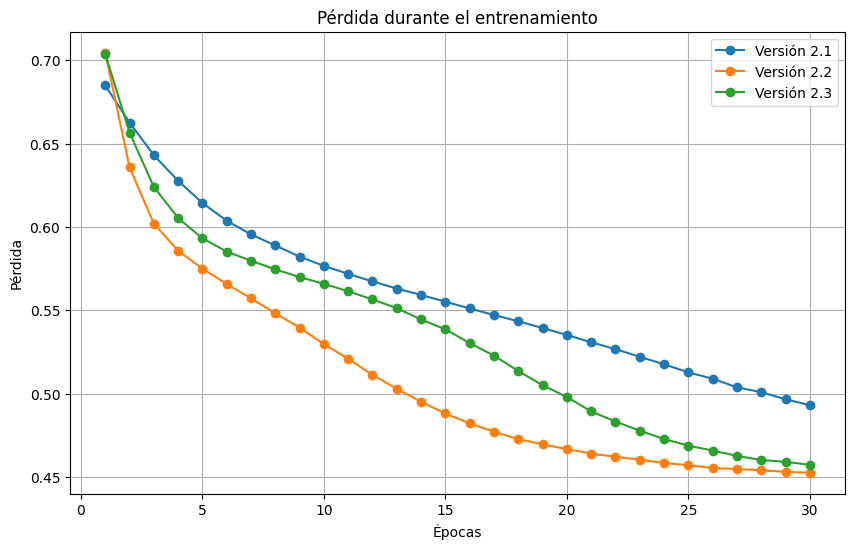

In [17]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_v2_1) + 1), loss_v2_1, marker='o', linestyle='-', label='Versión 2.1')
plt.plot(range(1, len(loss_v2_2) + 1), loss_v2_2, marker='o', linestyle='-', label='Versión 2.2')
plt.plot(range(1, len(loss_v2_3) + 1), loss_v2_3, marker='o', linestyle='-', label='Versión 2.3')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()

# Añadir leyenda
plt.legend(loc='best')  # Ajusta automáticamente la posición de la leyenda

# Mostrar el gráfico
plt.show()

In [18]:
recomendador_v2_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v2_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v2_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
print()
recomendador_v2_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v2_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v2_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
print()
recomendador_v2_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v2_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v2_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)

[+] Evaluation Results => Precision@5: 0.6862, Recall@5: 0.3042, NDCG@5: 0.7263
[+] Evaluation Results => Precision@5: 0.6927, Recall@5: 0.2943, NDCG@5: 0.7391
[+] Evaluation Results => Precision@5: 0.7350, Recall@5: 0.2949, NDCG@5: 0.7753

[+] Evaluation Results => Precision@10: 0.6894, Recall@10: 0.5655, NDCG@10: 0.7779
[+] Evaluation Results => Precision@10: 0.6894, Recall@10: 0.5655, NDCG@10: 0.7458
[+] Evaluation Results => Precision@10: 0.7301, Recall@10: 0.5855, NDCG@10: 0.7937

[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7995
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7763
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.8195


In [19]:
#  ████████╗██╗    ██╗ ██████╗ ████████╗ ██████╗ ██╗    ██╗███████╗██████╗ ███╗   ███╗ ██████╗ ██████╗ ███████╗██╗    ██╗   ██╗██████╗ 
#  ╚══██╔══╝██║    ██║██╔═══██╗╚══██╔══╝██╔═══██╗██║    ██║██╔════╝██╔══██╗████╗ ████║██╔═══██╗██╔══██╗██╔════╝██║    ██║   ██║╚════██╗
#     ██║   ██║ █╗ ██║██║   ██║   ██║   ██║   ██║██║ █╗ ██║█████╗  ██████╔╝██╔████╔██║██║   ██║██║  ██║█████╗  ██║    ██║   ██║ █████╔╝
#     ██║   ██║███╗██║██║   ██║   ██║   ██║   ██║██║███╗██║██╔══╝  ██╔══██╗██║╚██╔╝██║██║   ██║██║  ██║██╔══╝  ██║    ╚██╗ ██╔╝██╔═══╝ 
#     ██║   ╚███╔███╔╝╚██████╔╝   ██║   ╚██████╔╝╚███╔███╔╝███████╗██║  ██║██║ ╚═╝ ██║╚██████╔╝██████╔╝███████╗███████╗╚████╔╝ ███████╗
#     ╚═╝    ╚══╝╚══╝  ╚═════╝    ╚═╝    ╚═════╝  ╚══╝╚══╝ ╚══════╝╚═╝  ╚═╝╚═╝     ╚═╝ ╚═════╝ ╚═════╝ ╚══════╝╚══════╝ ╚═══╝  ╚══════╝

# V1
recomendador_v3_1 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModelV2, 
    User_Tower=UserTowerV1,
    Item_Tower=ItemTowerV1,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v3_1.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v3_1 = recomendador_v3_1.train()


# V2
recomendador_v3_2 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModelV2, 
    User_Tower=UserTowerV2,
    Item_Tower=ItemTowerV2,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v3_2.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v3_2 = recomendador_v3_2.train()


# V3
recomendador_v3_3 = TwoTowerRecommenderSystem(
    Two_Tower_Model=TwoTowerModelV2, 
    User_Tower=UserTowerV3,
    Item_Tower=ItemTowerV3,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v3_3.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v3_3 = recomendador_v3_3.train()

[+] Ítems cargados: 53 ítems con 12 características cada uno.
[+] Users cargados: 489 users con 11 características cada uno.
[+] Interactions cargados: 489 interactions con 53 características cada uno.
[+] Epoch 1/30 => Loss: 0.7051
[+] Epoch 2/30 => Loss: 0.6841
[+] Epoch 3/30 => Loss: 0.6653
[+] Epoch 4/30 => Loss: 0.6481
[+] Epoch 5/30 => Loss: 0.6315
[+] Epoch 6/30 => Loss: 0.6146
[+] Epoch 7/30 => Loss: 0.5981
[+] Epoch 8/30 => Loss: 0.5829
[+] Epoch 9/30 => Loss: 0.5679
[+] Epoch 10/30 => Loss: 0.5547
[+] Epoch 11/30 => Loss: 0.5444
[+] Epoch 12/30 => Loss: 0.5346
[+] Epoch 13/30 => Loss: 0.5292
[+] Epoch 14/30 => Loss: 0.5248
[+] Epoch 15/30 => Loss: 0.5212
[+] Epoch 16/30 => Loss: 0.5188
[+] Epoch 17/30 => Loss: 0.5138
[+] Epoch 18/30 => Loss: 0.5095
[+] Epoch 19/30 => Loss: 0.5025
[+] Epoch 20/30 => Loss: 0.4933
[+] Epoch 21/30 => Loss: 0.4819
[+] Epoch 22/30 => Loss: 0.4745
[+] Epoch 23/30 => Loss: 0.4660
[+] Epoch 24/30 => Loss: 0.4560
[+] Epoch 25/30 => Loss: 0.4469
[+] Epo

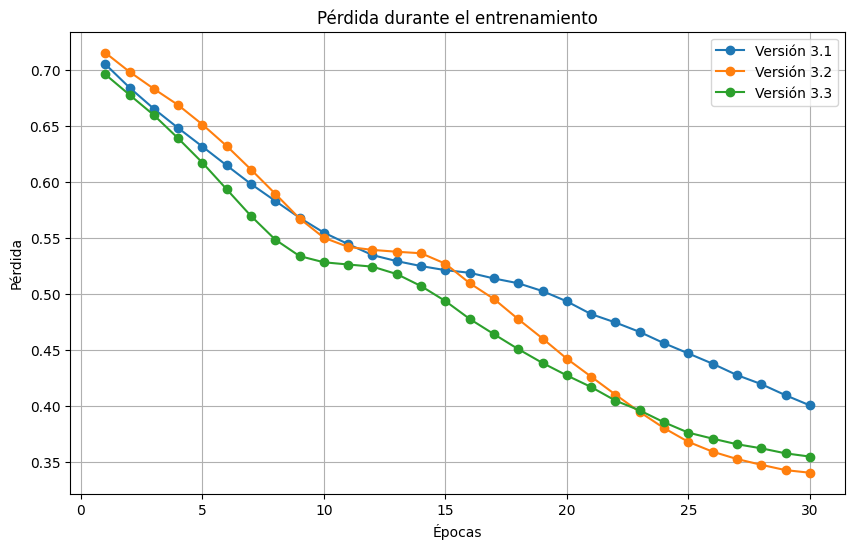

In [20]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_v3_1) + 1), loss_v3_1, marker='o', linestyle='-', label='Versión 3.1')
plt.plot(range(1, len(loss_v3_2) + 1), loss_v3_2, marker='o', linestyle='-', label='Versión 3.2')
plt.plot(range(1, len(loss_v3_3) + 1), loss_v3_3, marker='o', linestyle='-', label='Versión 3.3')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()

# Añadir leyenda
plt.legend(loc='best')  # Ajusta automáticamente la posición de la leyenda

# Mostrar el gráfico
plt.show()

In [21]:
recomendador_v3_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v3_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v3_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
print()
recomendador_v3_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v3_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v3_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
print()
recomendador_v3_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v3_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v3_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)

[+] Evaluation Results => Precision@5: 0.7236, Recall@5: 0.3215, NDCG@5: 0.7477
[+] Evaluation Results => Precision@5: 0.6878, Recall@5: 0.2609, NDCG@5: 0.7130
[+] Evaluation Results => Precision@5: 0.5642, Recall@5: 0.2070, NDCG@5: 0.5061

[+] Evaluation Results => Precision@10: 0.7138, Recall@10: 0.5909, NDCG@10: 0.7796
[+] Evaluation Results => Precision@10: 0.6894, Recall@10: 0.5655, NDCG@10: 0.7053
[+] Evaluation Results => Precision@10: 0.6285, Recall@10: 0.4682, NDCG@10: 0.5860

[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7961
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7428
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.6934


In [22]:
#  ██╗███╗   ██╗████████╗████████╗ ██████╗ ██╗    ██╗███████╗██████╗ 
#  ██║████╗  ██║╚══██╔══╝╚══██╔══╝██╔═══██╗██║    ██║██╔════╝██╔══██╗
#  ██║██╔██╗ ██║   ██║      ██║   ██║   ██║██║ █╗ ██║█████╗  ██████╔╝
#  ██║██║╚██╗██║   ██║      ██║   ██║   ██║██║███╗██║██╔══╝  ██╔══██╗
#  ██║██║ ╚████║   ██║      ██║   ╚██████╔╝╚███╔███╔╝███████╗██║  ██║
#  ╚═╝╚═╝  ╚═══╝   ╚═╝      ╚═╝    ╚═════╝  ╚══╝╚══╝ ╚══════╝╚═╝  ╚═╝

# V1
recomendador_v4_1 = TwoTowerRecommenderSystem(
    Two_Tower_Model=IntTower, 
    User_Tower=UserTowerV1,
    Item_Tower=ItemTowerV1,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v4_1.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v4_1 = recomendador_v4_1.train()


# V2
recomendador_v4_2 = TwoTowerRecommenderSystem(
    Two_Tower_Model=IntTower, 
    User_Tower=UserTowerV2,
    Item_Tower=ItemTowerV2,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v4_2.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v4_2 = recomendador_v4_2.train()


# V3
recomendador_v4_3 = TwoTowerRecommenderSystem(
    Two_Tower_Model=IntTower, 
    User_Tower=UserTowerV3,
    Item_Tower=ItemTowerV3,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v4_3.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v4_3 = recomendador_v4_3.train()

[+] Ítems cargados: 53 ítems con 12 características cada uno.
[+] Users cargados: 489 users con 11 características cada uno.
[+] Interactions cargados: 489 interactions con 53 características cada uno.
[+] Epoch 1/30 => Loss: 0.7185
[+] Epoch 2/30 => Loss: 0.6984
[+] Epoch 3/30 => Loss: 0.6785
[+] Epoch 4/30 => Loss: 0.6586
[+] Epoch 5/30 => Loss: 0.6377
[+] Epoch 6/30 => Loss: 0.6161
[+] Epoch 7/30 => Loss: 0.5948
[+] Epoch 8/30 => Loss: 0.5741
[+] Epoch 9/30 => Loss: 0.5557
[+] Epoch 10/30 => Loss: 0.5414
[+] Epoch 11/30 => Loss: 0.5304
[+] Epoch 12/30 => Loss: 0.5262
[+] Epoch 13/30 => Loss: 0.5263
[+] Epoch 14/30 => Loss: 0.5272
[+] Epoch 15/30 => Loss: 0.5266
[+] Epoch 16/30 => Loss: 0.5232
[+] Epoch 17/30 => Loss: 0.5166
[+] Epoch 18/30 => Loss: 0.5077
[+] Epoch 19/30 => Loss: 0.4986
[+] Epoch 20/30 => Loss: 0.4888
[+] Epoch 21/30 => Loss: 0.4792
[+] Epoch 22/30 => Loss: 0.4716
[+] Epoch 23/30 => Loss: 0.4636
[+] Epoch 24/30 => Loss: 0.4565
[+] Epoch 25/30 => Loss: 0.4503
[+] Epo

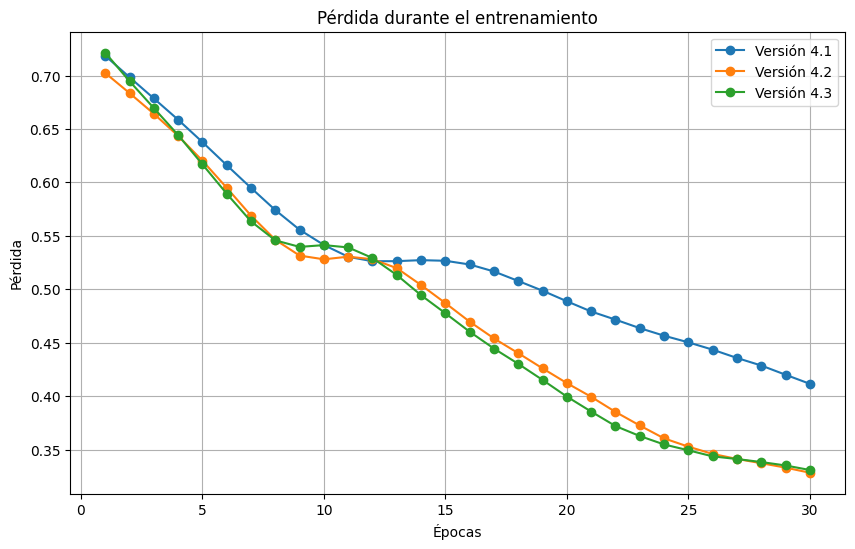

In [23]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_v4_1) + 1), loss_v4_1, marker='o', linestyle='-', label='Versión 4.1')
plt.plot(range(1, len(loss_v4_2) + 1), loss_v4_2, marker='o', linestyle='-', label='Versión 4.2')
plt.plot(range(1, len(loss_v4_3) + 1), loss_v4_3, marker='o', linestyle='-', label='Versión 4.3')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()

# Añadir leyenda
plt.legend(loc='best')  # Ajusta automáticamente la posición de la leyenda

# Mostrar el gráfico
plt.show()

In [24]:
recomendador_v4_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v4_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v4_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
print()
recomendador_v4_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v4_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v4_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
print()
recomendador_v4_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v4_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v4_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)

[+] Evaluation Results => Precision@5: 0.7350, Recall@5: 0.3296, NDCG@5: 0.7583
[+] Evaluation Results => Precision@5: 0.7171, Recall@5: 0.2749, NDCG@5: 0.7266
[+] Evaluation Results => Precision@5: 0.5008, Recall@5: 0.1762, NDCG@5: 0.4594

[+] Evaluation Results => Precision@10: 0.7138, Recall@10: 0.5909, NDCG@10: 0.7982
[+] Evaluation Results => Precision@10: 0.6423, Recall@10: 0.5086, NDCG@10: 0.6526
[+] Evaluation Results => Precision@10: 0.6285, Recall@10: 0.4682, NDCG@10: 0.5816

[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.8013
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7327
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.6943


In [25]:
#  ██████╗ ███████╗██╗   ██╗ ██████╗ ███╗   ██╗██████╗     ████████╗██╗    ██╗ ██████╗    ████████╗ ██████╗ ██╗    ██╗███████╗██████╗ 
#  ██╔══██╗██╔════╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔══██╗    ╚══██╔══╝██║    ██║██╔═══██╗   ╚══██╔══╝██╔═══██╗██║    ██║██╔════╝██╔══██╗
#  ██████╔╝█████╗   ╚████╔╝ ██║   ██║██╔██╗ ██║██║  ██║       ██║   ██║ █╗ ██║██║   ██║█████╗██║   ██║   ██║██║ █╗ ██║█████╗  ██████╔╝
#  ██╔══██╗██╔══╝    ╚██╔╝  ██║   ██║██║╚██╗██║██║  ██║       ██║   ██║███╗██║██║   ██║╚════╝██║   ██║   ██║██║███╗██║██╔══╝  ██╔══██╗
#  ██████╔╝███████╗   ██║   ╚██████╔╝██║ ╚████║██████╔╝       ██║   ╚███╔███╔╝╚██████╔╝      ██║   ╚██████╔╝╚███╔███╔╝███████╗██║  ██║
#  ╚═════╝ ╚══════╝   ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚═════╝        ╚═╝    ╚══╝╚══╝  ╚═════╝       ╚═╝    ╚═════╝  ╚══╝╚══╝ ╚══════╝╚═╝  ╚═╝

# V1
recomendador_v5_1 = TwoTowerRecommenderSystem(
    Two_Tower_Model=SparseTwoTower, 
    User_Tower=UserTowerV1,
    Item_Tower=ItemTowerV1,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v5_1.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v5_1 = recomendador_v5_1.train()


# V2
recomendador_v5_2 = TwoTowerRecommenderSystem(
    Two_Tower_Model=SparseTwoTower, 
    User_Tower=UserTowerV2,
    Item_Tower=ItemTowerV2,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v5_2.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v5_2 = recomendador_v5_2.train()


# V3
recomendador_v5_3 = TwoTowerRecommenderSystem(
    Two_Tower_Model=SparseTwoTower, 
    User_Tower=UserTowerV3,
    Item_Tower=ItemTowerV3,
    user_input_size=df_train_users.shape[1] - 1,
    item_input_size=df_items.shape[1] - 1,
)
recomendador_v5_3.load_data_train(data_items=df_items, data_users=df_train_users, data_interactions=df_train_interacciones)
loss_v5_3 = recomendador_v5_3.train()

[+] Ítems cargados: 53 ítems con 12 características cada uno.
[+] Users cargados: 489 users con 11 características cada uno.
[+] Interactions cargados: 489 interactions con 53 características cada uno.
[+] Epoch 1/30 => Loss: 0.6195
[+] Epoch 2/30 => Loss: 0.5823
[+] Epoch 3/30 => Loss: 0.5541
[+] Epoch 4/30 => Loss: 0.5338
[+] Epoch 5/30 => Loss: 0.5186
[+] Epoch 6/30 => Loss: 0.5090
[+] Epoch 7/30 => Loss: 0.5020
[+] Epoch 8/30 => Loss: 0.4945
[+] Epoch 9/30 => Loss: 0.4831
[+] Epoch 10/30 => Loss: 0.4706
[+] Epoch 11/30 => Loss: 0.4513
[+] Epoch 12/30 => Loss: 0.4359
[+] Epoch 13/30 => Loss: 0.4140
[+] Epoch 14/30 => Loss: 0.3969
[+] Epoch 15/30 => Loss: 0.3816
[+] Epoch 16/30 => Loss: 0.3713
[+] Epoch 17/30 => Loss: 0.3637
[+] Epoch 18/30 => Loss: 0.3591
[+] Epoch 19/30 => Loss: 0.3524
[+] Epoch 20/30 => Loss: 0.3528
[+] Epoch 21/30 => Loss: 0.3523
[+] Epoch 22/30 => Loss: 0.3487
[+] Epoch 23/30 => Loss: 0.3442
[+] Epoch 24/30 => Loss: 0.3422
[+] Epoch 25/30 => Loss: 0.3340
[+] Epo

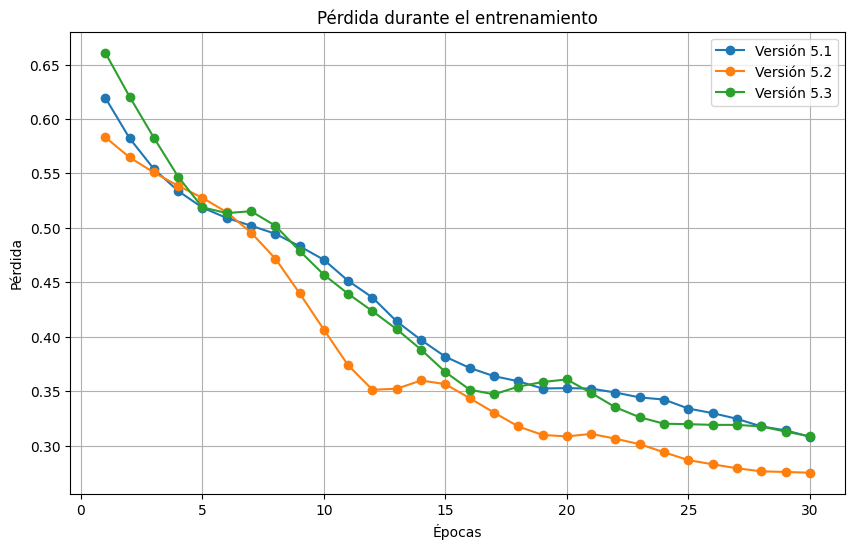

In [26]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_v5_1) + 1), loss_v5_1, marker='o', linestyle='-', label='Versión 5.1')
plt.plot(range(1, len(loss_v5_2) + 1), loss_v5_2, marker='o', linestyle='-', label='Versión 5.2')
plt.plot(range(1, len(loss_v5_3) + 1), loss_v5_3, marker='o', linestyle='-', label='Versión 5.3')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()

# Añadir leyenda
plt.legend(loc='best')  # Ajusta automáticamente la posición de la leyenda

# Mostrar el gráfico
plt.show()

In [27]:
recomendador_v5_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v5_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
recomendador_v5_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=5)
print()
recomendador_v5_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v5_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
recomendador_v5_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=10)
print()
recomendador_v5_1.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v5_2.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)
recomendador_v5_3.evaluate(val_users=df_validation_users, val_interactions=df_validation_interacciones, k=15)

[+] Evaluation Results => Precision@5: 0.7285, Recall@5: 0.3267, NDCG@5: 0.7498
[+] Evaluation Results => Precision@5: 0.7789, Recall@5: 0.3458, NDCG@5: 0.8241
[+] Evaluation Results => Precision@5: 0.7545, Recall@5: 0.3539, NDCG@5: 0.7881

[+] Evaluation Results => Precision@10: 0.7000, Recall@10: 0.5822, NDCG@10: 0.7711
[+] Evaluation Results => Precision@10: 0.7211, Recall@10: 0.5922, NDCG@10: 0.8085
[+] Evaluation Results => Precision@10: 0.7455, Recall@10: 0.6402, NDCG@10: 0.8354

[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.7978
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.8369
[+] Evaluation Results => Precision@15: 0.6705, Recall@15: 0.8221, NDCG@15: 0.8441


In [28]:
recommended_items_v1_1 = {}
recommended_items_v1_2 = {}
recommended_items_v1_3 = {}

recommended_items_v2_1 = {}
recommended_items_v2_2 = {}
recommended_items_v2_3 = {}

recommended_items_v3_1 = {}
recommended_items_v3_2 = {}
recommended_items_v3_3 = {}

recommended_items_v4_1 = {}
recommended_items_v4_2 = {}
recommended_items_v4_3 = {}

recommended_items_v5_1 = {}
recommended_items_v5_2 = {}
recommended_items_v5_3 = {}


# Iterar sobre todos los usuarios en el conjunto de prueba
for user_id in df_test_users['id_estudiante']:
    
    # Obtener las características del usuario actual
    user = df_test_users[df_test_users['id_estudiante'] == user_id]
    interacted = [i for i, interaction in enumerate(df_test_interacciones[df_test_interacciones['id_estudiante'] == user_id].iloc[:, 1:].values.flatten()) if interaction == 1]
    
    # Recomendaciones
    recommendations_v1_1 = recomendador_v1_1.recommend(user, interacted, top_k=10)
    recommendations_v1_2 = recomendador_v1_2.recommend(user, interacted, top_k=10)
    recommendations_v1_3 = recomendador_v1_3.recommend(user, interacted, top_k=10)

    recommendations_v2_1 = recomendador_v2_1.recommend(user, interacted, top_k=10)
    recommendations_v2_2 = recomendador_v2_2.recommend(user, interacted, top_k=10)
    recommendations_v2_3 = recomendador_v2_3.recommend(user, interacted, top_k=10)

    recommendations_v3_1 = recomendador_v3_1.recommend(user, interacted, top_k=10)
    recommendations_v3_2 = recomendador_v3_2.recommend(user, interacted, top_k=10)
    recommendations_v3_3 = recomendador_v3_3.recommend(user, interacted, top_k=10)

    recommendations_v4_1 = recomendador_v4_1.recommend(user, interacted, top_k=10)
    recommendations_v4_2 = recomendador_v4_2.recommend(user, interacted, top_k=10)
    recommendations_v4_3 = recomendador_v4_3.recommend(user, interacted, top_k=10)

    recommendations_v5_1 = recomendador_v5_1.recommend(user, interacted, top_k=10)
    recommendations_v5_2 = recomendador_v5_2.recommend(user, interacted, top_k=10)
    recommendations_v5_3 = recomendador_v5_3.recommend(user, interacted, top_k=10)

    # Items recomendados

    recommended_items_v1_1[user_id] = [rec[0] for rec in recommendations_v1_1] 
    recommended_items_v1_2[user_id] = [rec[0] for rec in recommendations_v1_2]
    recommended_items_v1_3[user_id] = [rec[0] for rec in recommendations_v1_3]

    recommended_items_v2_1[user_id] = [rec[0] for rec in recommendations_v2_1] 
    recommended_items_v2_2[user_id] = [rec[0] for rec in recommendations_v2_2]
    recommended_items_v2_3[user_id] = [rec[0] for rec in recommendations_v2_3]

    recommended_items_v3_1[user_id] = [rec[0] for rec in recommendations_v3_1] 
    recommended_items_v3_2[user_id] = [rec[0] for rec in recommendations_v3_2]
    recommended_items_v3_3[user_id] = [rec[0] for rec in recommendations_v3_3]

    recommended_items_v4_1[user_id] = [rec[0] for rec in recommendations_v4_1] 
    recommended_items_v4_2[user_id] = [rec[0] for rec in recommendations_v4_2]
    recommended_items_v4_3[user_id] = [rec[0] for rec in recommendations_v4_3]

    recommended_items_v5_1[user_id] = [rec[0] for rec in recommendations_v5_1] 
    recommended_items_v5_2[user_id] = [rec[0] for rec in recommendations_v5_2]
    recommended_items_v5_3[user_id] = [rec[0] for rec in recommendations_v5_3]

In [29]:
recomendador_v1_1.evaluate_relevance(
    recommended_items=recommended_items_v1_1,
    popularity_bias=popularidad_items
)

recomendador_v1_2.evaluate_relevance(
    recommended_items=recommended_items_v1_2,
    popularity_bias=popularidad_items
)

recomendador_v1_3.evaluate_relevance(
    recommended_items=recommended_items_v1_3,
    popularity_bias=popularidad_items
)

Convergencia: 0.6792, Novedad: -0.9593, Sesgo de Popularidad: 234.2877
Convergencia: 0.6981, Novedad: -4.7316, Sesgo de Popularidad: 250.4558
Convergencia: 0.6981, Novedad: -4.3370, Sesgo de Popularidad: 244.6766


In [30]:
recomendador_v2_1.evaluate_relevance(
    recommended_items=recommended_items_v2_1,
    popularity_bias=popularidad_items
)

recomendador_v2_2.evaluate_relevance(
    recommended_items=recommended_items_v2_2,
    popularity_bias=popularidad_items
)

recomendador_v2_3.evaluate_relevance(
    recommended_items=recommended_items_v2_3,
    popularity_bias=popularidad_items
)

Convergencia: 0.5472, Novedad: 0.9962, Sesgo de Popularidad: 218.4253
Convergencia: 0.5472, Novedad: 0.5347, Sesgo de Popularidad: 224.8851
Convergencia: 0.5472, Novedad: 0.7247, Sesgo de Popularidad: 220.1247


In [31]:
recomendador_v3_1.evaluate_relevance(
    recommended_items=recommended_items_v3_1,
    popularity_bias=popularidad_items
)

recomendador_v3_2.evaluate_relevance(
    recommended_items=recommended_items_v3_2,
    popularity_bias=popularidad_items
)

recomendador_v3_3.evaluate_relevance(
    recommended_items=recommended_items_v3_3,
    popularity_bias=popularidad_items
)

Convergencia: 0.7736, Novedad: 7.7072, Sesgo de Popularidad: 74.2955
Convergencia: 0.6038, Novedad: -0.2205, Sesgo de Popularidad: 233.8039
Convergencia: 0.5472, Novedad: 0.1362, Sesgo de Popularidad: 228.3961


In [32]:
recomendador_v4_1.evaluate_relevance(
    recommended_items=recommended_items_v4_1,
    popularity_bias=popularidad_items
)

recomendador_v4_2.evaluate_relevance(
    recommended_items=recommended_items_v4_2,
    popularity_bias=popularidad_items
)

recomendador_v4_3.evaluate_relevance(
    recommended_items=recommended_items_v4_3,
    popularity_bias=popularidad_items
)

Convergencia: 0.6604, Novedad: 1.6912, Sesgo de Popularidad: 199.5669
Convergencia: 0.6792, Novedad: -0.4664, Sesgo de Popularidad: 233.3097
Convergencia: 0.5472, Novedad: 0.1362, Sesgo de Popularidad: 228.3948


In [33]:
recomendador_v5_1.evaluate_relevance(
    recommended_items=recommended_items_v5_1,
    popularity_bias=popularidad_items
)

recomendador_v5_2.evaluate_relevance(
    recommended_items=recommended_items_v5_2,
    popularity_bias=popularidad_items
)

recomendador_v5_3.evaluate_relevance(
    recommended_items=recommended_items_v5_3,
    popularity_bias=popularidad_items
)

Convergencia: 0.3585, Novedad: 12.7412, Sesgo de Popularidad: 5.2279
Convergencia: 0.6981, Novedad: 6.7258, Sesgo de Popularidad: 114.2104
Convergencia: 0.6226, Novedad: -0.9896, Sesgo de Popularidad: 236.0136


In [34]:

#  ██████╗ ███████╗ ██████╗ ██████╗ ███╗   ███╗███████╗███╗   ██╗██████╗  █████╗  ██████╗██╗ ██████╗ ███╗   ██╗███████╗███████╗
#  ██╔══██╗██╔════╝██╔════╝██╔═══██╗████╗ ████║██╔════╝████╗  ██║██╔══██╗██╔══██╗██╔════╝██║██╔═══██╗████╗  ██║██╔════╝██╔════╝
#  ██████╔╝█████╗  ██║     ██║   ██║██╔████╔██║█████╗  ██╔██╗ ██║██║  ██║███████║██║     ██║██║   ██║██╔██╗ ██║█████╗  ███████╗
#  ██╔══██╗██╔══╝  ██║     ██║   ██║██║╚██╔╝██║██╔══╝  ██║╚██╗██║██║  ██║██╔══██║██║     ██║██║   ██║██║╚██╗██║██╔══╝  ╚════██║
#  ██║  ██║███████╗╚██████╗╚██████╔╝██║ ╚═╝ ██║███████╗██║ ╚████║██████╔╝██║  ██║╚██████╗██║╚██████╔╝██║ ╚████║███████╗███████║
#  ╚═╝  ╚═╝╚══════╝ ╚═════╝ ╚═════╝ ╚═╝     ╚═╝╚══════╝╚═╝  ╚═══╝╚═════╝ ╚═╝  ╚═╝ ╚═════╝╚═╝ ╚═════╝ ╚═╝  ╚═══╝╚══════╝╚══════╝
#   ██████╗ ██╗      ██████╗ ██████╗  █████╗ ██╗     ███████╗███████╗
#  ██╔════╝ ██║     ██╔═══██╗██╔══██╗██╔══██╗██║     ██╔════╝██╔════╝
#  ██║  ███╗██║     ██║   ██║██████╔╝███████║██║     █████╗  ███████╗
#  ██║   ██║██║     ██║   ██║██╔══██╗██╔══██║██║     ██╔══╝  ╚════██║
#  ╚██████╔╝███████╗╚██████╔╝██████╔╝██║  ██║███████╗███████╗███████║
#   ╚═════╝ ╚══════╝ ╚═════╝ ╚═════╝ ╚═╝  ╚═╝╚══════╝╚══════╝╚══════╝

In [35]:
def diferencias_resultados_recomendaciones(columnas: list[str], df_ejercicios: pd.DataFrame, df_usuarios: pd.DataFrame, df_interacciones: pd.DataFrame, items_recomendados: dict[int, list]):
    df_ejercicios_copia = df_ejercicios[['id_ejercicio'] + columnas]
    df_resultados_recomendaciones = pd.DataFrame(columns=columnas)

    for user_id in df_usuarios['id_estudiante']:
        
        interacciones = [i for i, interaccion in enumerate(df_interacciones[df_interacciones['id_estudiante'] == user_id].iloc[:, 1:].values.flatten()) if interaccion == 1]
        ejercicios_realizados = df_ejercicios_copia[df_ejercicios_copia['id_ejercicio'].isin(interacciones)]
        recomendaciones = df_ejercicios_copia[df_ejercicios_copia['id_ejercicio'].isin(items_recomendados.get(user_id))]

        ejericios_realizados_media = ejercicios_realizados.select_dtypes(include='number').mean().to_frame().T
        recomendaciones_media = recomendaciones.select_dtypes(include='number').mean().to_frame().T

        df_diferencia = recomendaciones_media - ejericios_realizados_media
        df_diferencia = df_diferencia.drop(labels=['id_ejercicio'], axis=1)
        valores_diferencia = df_diferencia.values.flatten().tolist()

        fila = dict(zip(columnas, valores_diferencia))
        df_resultados_recomendaciones = pd.concat([df_resultados_recomendaciones, pd.DataFrame([fila])], ignore_index=True)

    return df_resultados_recomendaciones


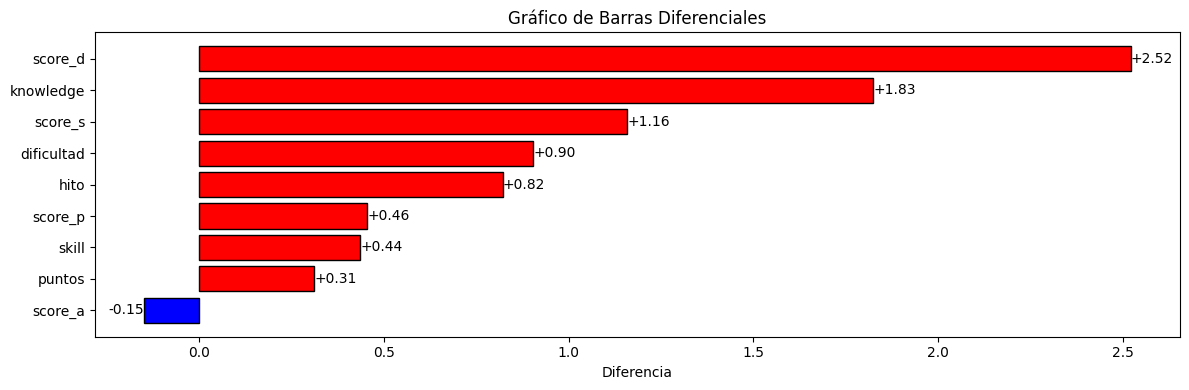

In [36]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v1_1
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

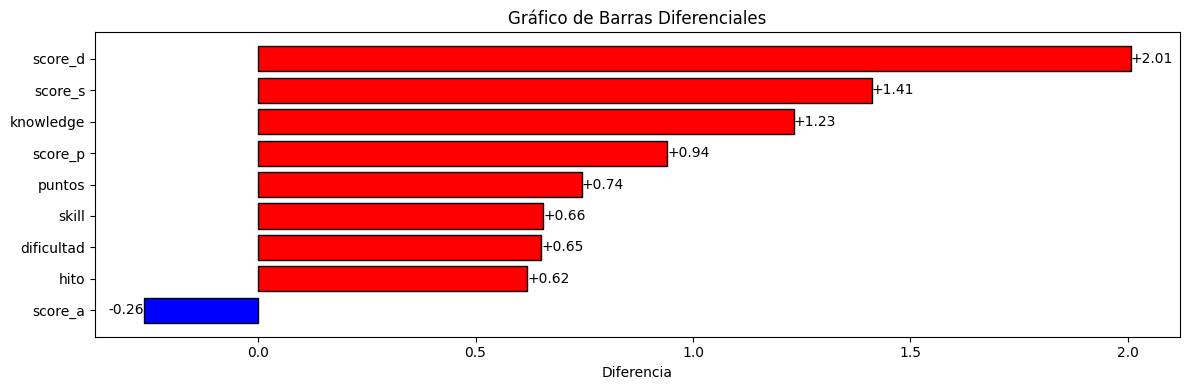

In [37]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v1_2
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

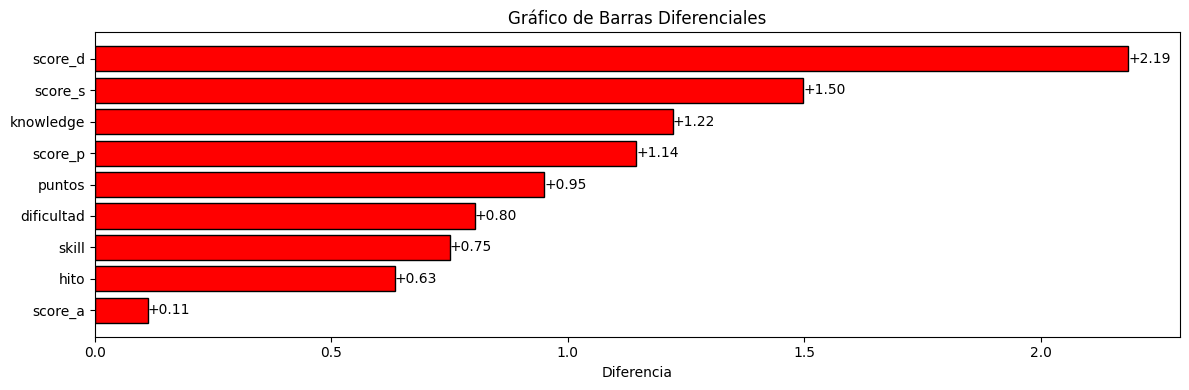

In [38]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v1_3
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

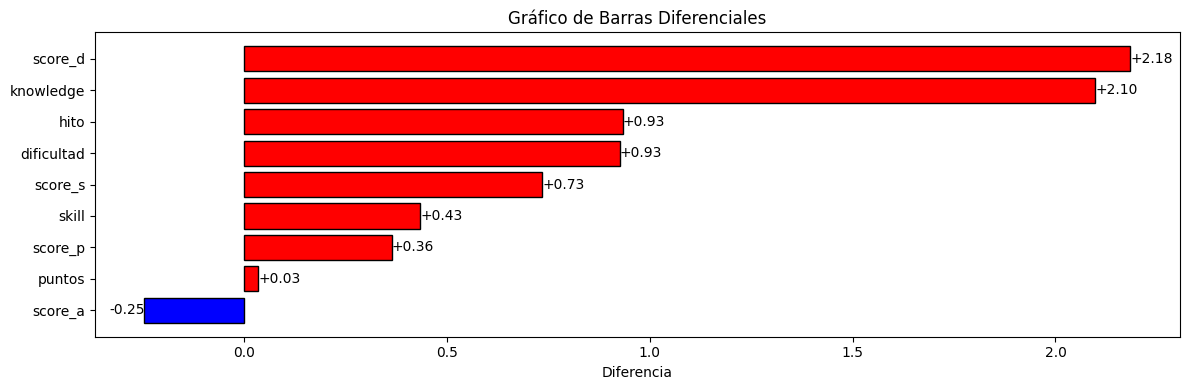

In [39]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v2_1
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

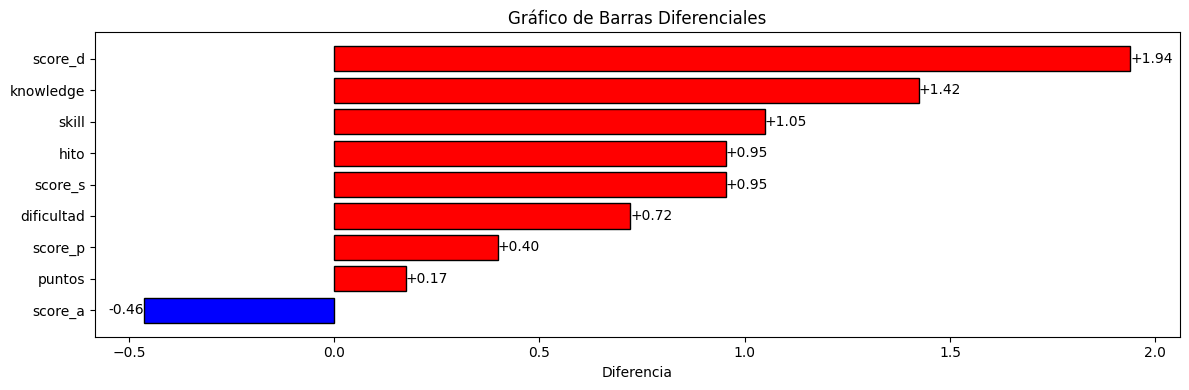

In [40]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v2_2
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

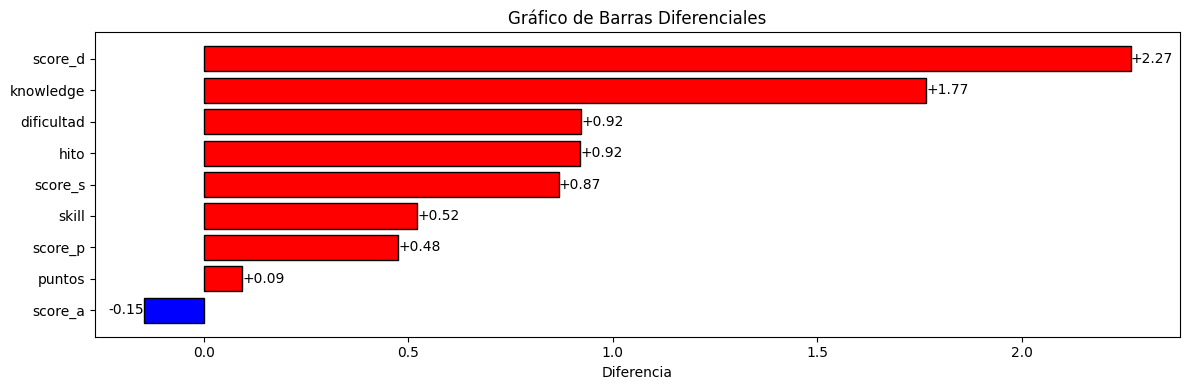

In [41]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v2_3
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

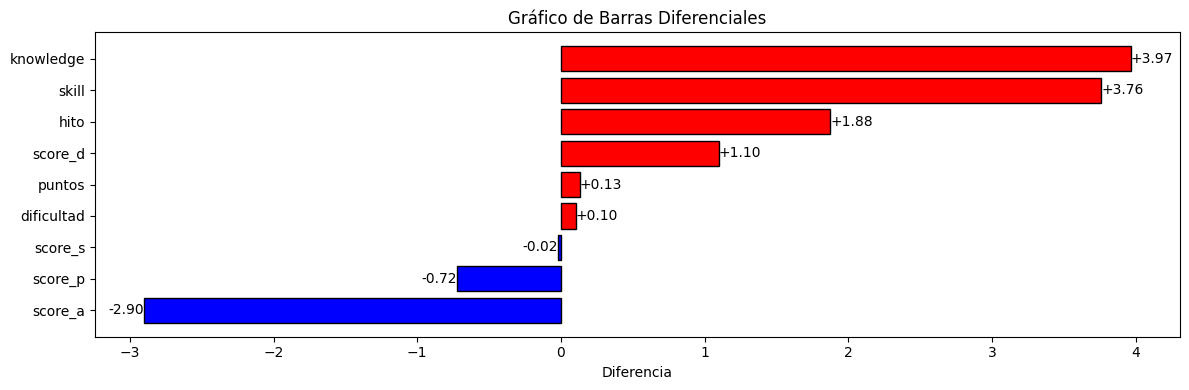

In [42]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v3_1
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

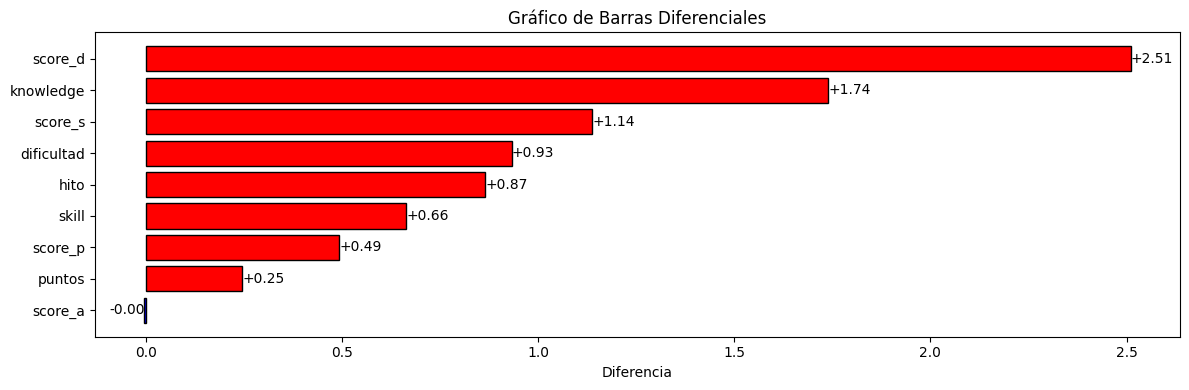

In [43]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v3_2
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

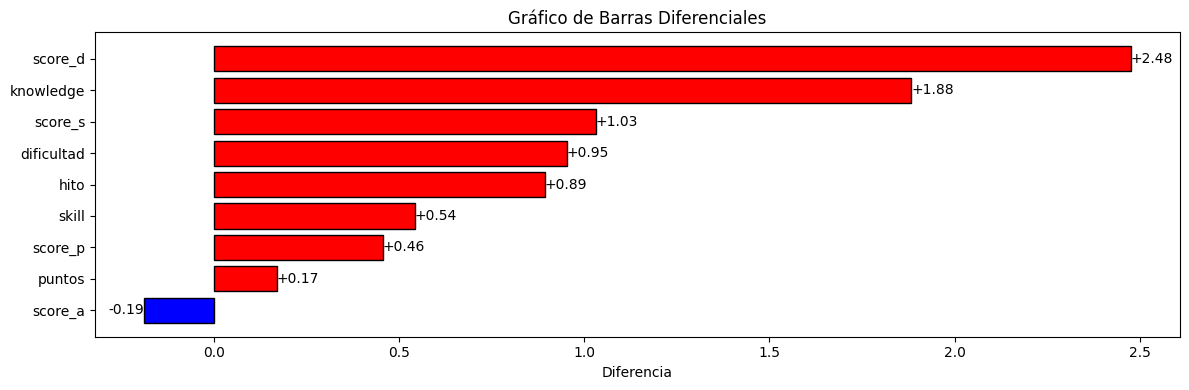

In [44]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v3_3
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

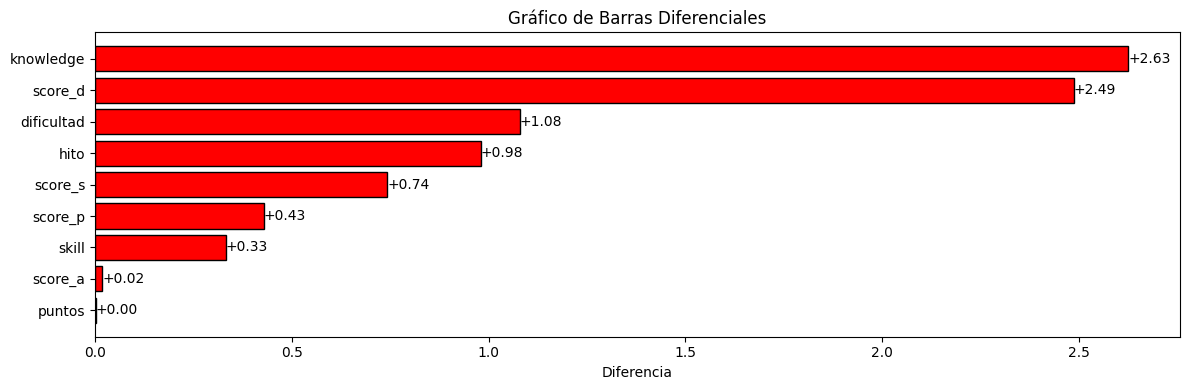

In [45]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v4_1
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

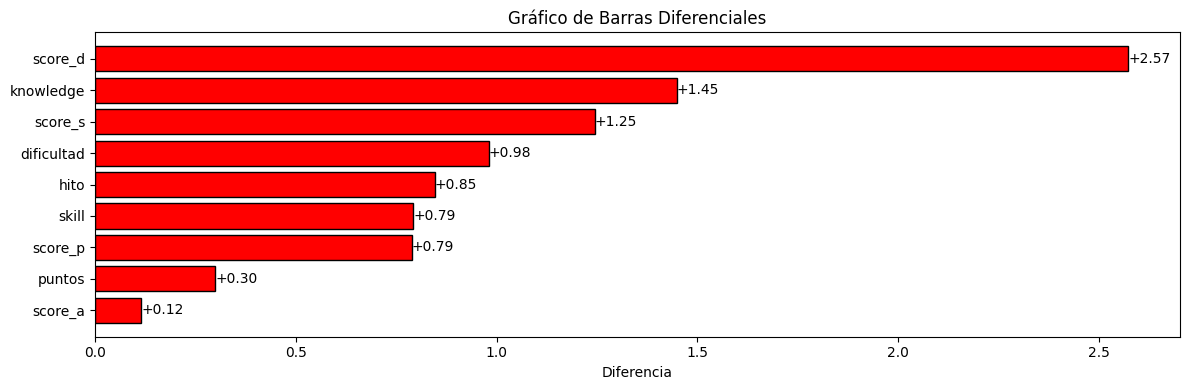

In [46]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v4_2
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

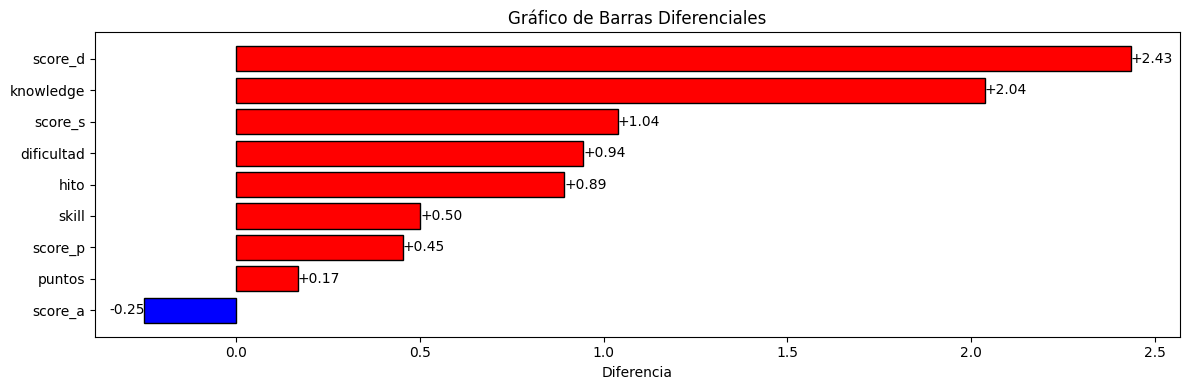

In [47]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v4_3
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

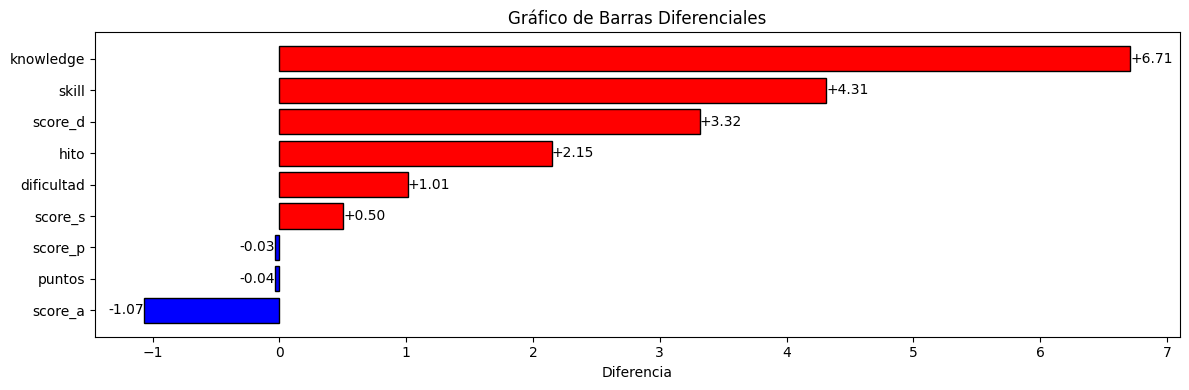

In [48]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v5_1
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

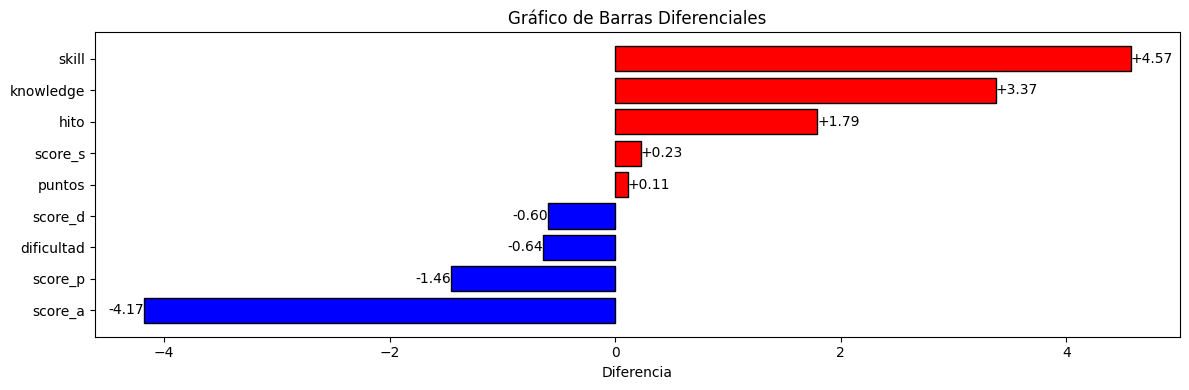

In [49]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v5_2
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

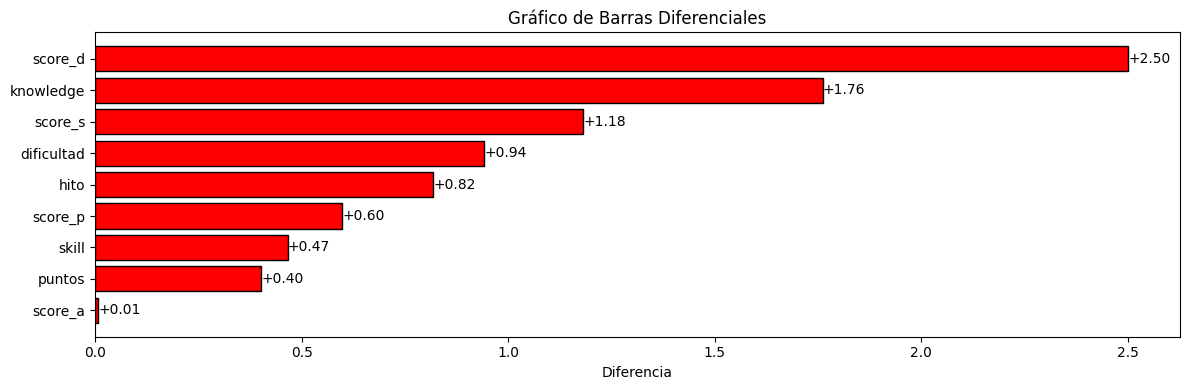

In [50]:
df_resultados_recomendaciones = diferencias_resultados_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_usuarios=df_test_users,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v5_3
)

import matplotlib.pyplot as plt
import numpy as np

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

In [51]:
#  ██████╗ ███████╗ ██████╗ ██████╗ ███╗   ███╗███████╗███╗   ██╗██████╗  █████╗  ██████╗██╗ ██████╗ ███╗   ██╗███████╗███████╗
#  ██╔══██╗██╔════╝██╔════╝██╔═══██╗████╗ ████║██╔════╝████╗  ██║██╔══██╗██╔══██╗██╔════╝██║██╔═══██╗████╗  ██║██╔════╝██╔════╝
#  ██████╔╝█████╗  ██║     ██║   ██║██╔████╔██║█████╗  ██╔██╗ ██║██║  ██║███████║██║     ██║██║   ██║██╔██╗ ██║█████╗  ███████╗
#  ██╔══██╗██╔══╝  ██║     ██║   ██║██║╚██╔╝██║██╔══╝  ██║╚██╗██║██║  ██║██╔══██║██║     ██║██║   ██║██║╚██╗██║██╔══╝  ╚════██║
#  ██║  ██║███████╗╚██████╗╚██████╔╝██║ ╚═╝ ██║███████╗██║ ╚████║██████╔╝██║  ██║╚██████╗██║╚██████╔╝██║ ╚████║███████╗███████║
#  ╚═╝  ╚═╝╚══════╝ ╚═════╝ ╚═════╝ ╚═╝     ╚═╝╚══════╝╚═╝  ╚═══╝╚═════╝ ╚═╝  ╚═╝ ╚═════╝╚═╝ ╚═════╝ ╚═╝  ╚═══╝╚══════╝╚══════╝

#  ██╗███╗   ██╗██████╗ ██╗██╗   ██╗██╗██████╗ ██╗   ██╗ █████╗ ██╗     ███████╗███████╗
#  ██║████╗  ██║██╔══██╗██║██║   ██║██║██╔══██╗██║   ██║██╔══██╗██║     ██╔════╝██╔════╝
#  ██║██╔██╗ ██║██║  ██║██║██║   ██║██║██║  ██║██║   ██║███████║██║     █████╗  ███████╗
#  ██║██║╚██╗██║██║  ██║██║╚██╗ ██╔╝██║██║  ██║██║   ██║██╔══██║██║     ██╔══╝  ╚════██║
#  ██║██║ ╚████║██████╔╝██║ ╚████╔╝ ██║██████╔╝╚██████╔╝██║  ██║███████╗███████╗███████║
#  ╚═╝╚═╝  ╚═══╝╚═════╝ ╚═╝  ╚═══╝  ╚═╝╚═════╝  ╚═════╝ ╚═╝  ╚═╝╚══════╝╚══════╝╚══════╝

In [52]:
def diferencias_recomendaciones(columnas: list[str], df_ejercicios: pd.DataFrame, df_interacciones: pd.DataFrame, items_recomendados: dict[int, list], usuario_id: int):
    
    df_ejercicios_copia = df_ejercicios[['id_ejercicio'] + columnas]
    df_resultados_recomendaciones = pd.DataFrame(columns=columnas)

    interacciones = [i for i, interaccion in enumerate(df_interacciones[df_interacciones['id_estudiante'] == usuario_id].iloc[:, 1:].values.flatten()) if interaccion == 1]

    ejercicios_realizados = df_ejercicios_copia[df_ejercicios_copia['id_ejercicio'].isin(interacciones)]

    recomendaciones = df_ejercicios_copia[df_ejercicios_copia['id_ejercicio'].isin(items_recomendados.get(usuario_id))]

    ejericios_realizados_media = ejercicios_realizados.select_dtypes(include='number').mean().to_frame().T
    recomendaciones_media = recomendaciones.select_dtypes(include='number').mean().to_frame().T

    df_diferencia = recomendaciones_media - ejericios_realizados_media
    df_diferencia = df_diferencia.drop(labels=['id_ejercicio'], axis=1)
    valores_diferencia = df_diferencia.values.flatten().tolist()

    fila = dict(zip(columnas, valores_diferencia))
    df_resultados_recomendaciones = pd.concat([df_resultados_recomendaciones, pd.DataFrame([fila])], ignore_index=True)

    return df_resultados_recomendaciones

In [53]:
df_test_users

,id_estudiante,exitosos,fallidos,score_a,score_p,score_d,score_s,BACHILLERATO EN CIENCIAS,INGENIERIA CIVIL INDUSTRIAL,INGENIERIA CIVIL INFORMATICA,INGENIERIA EN COMPUTACION E INFORMATICA,INGENIERIA INDUSTRIAL
754,926,0.038462,0.325,0.000000,0.2,0.25,0.25,0,1,0,0,0
985,1184,0.288462,0.000,0.000000,0.2,0.25,0.25,0,0,1,0,0
353,391,0.269231,0.600,0.428571,0.6,0.75,0.75,0,0,1,0,0
897,1083,0.269231,0.400,0.000000,0.2,0.25,0.25,0,0,1,0,0
337,375,0.346154,0.300,0.857143,0.8,1.00,0.75,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
344,382,0.288462,0.375,0.285714,0.4,0.00,0.25,0,1,0,0,0
245,272,0.192308,0.325,0.428571,1.0,0.50,0.75,0,0,1,0,0
349,387,0.326923,0.325,0.714286,1.0,0.75,0.75,0,0,1,0,0
60,68,0.288462,0.575,0.714286,1.0,0.75,0.75,0,0,0,1,0


In [54]:
import matplotlib.pyplot as plt
import numpy as np


usuario_id = df_test_users['id_estudiante'].sample(1, random_state=VAR_SEED).iloc[0]
print(f'Estudiante: {usuario_id}')

Estudiante: 922


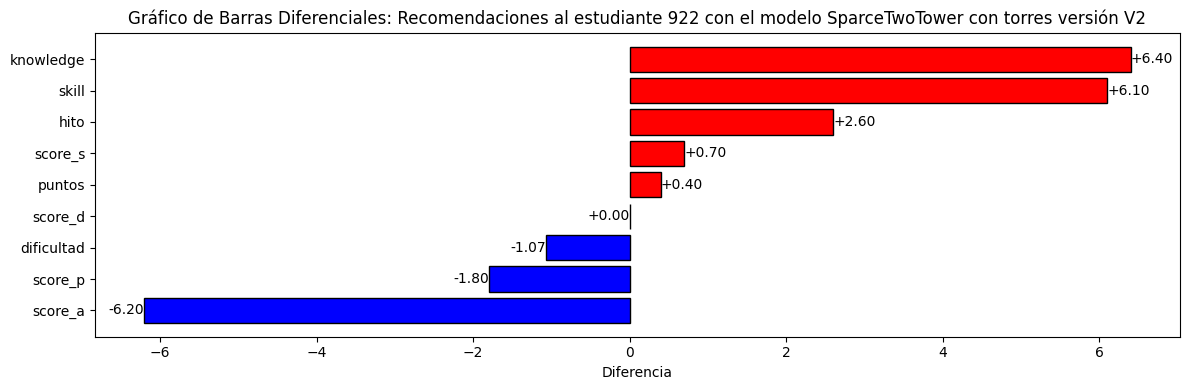

In [55]:
df_resultados_recomendaciones = diferencias_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v5_2,
    usuario_id=usuario_id
)

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title(f'Gráfico de Barras Diferenciales: Recomendaciones al estudiante {usuario_id} con el modelo SparceTwoTower con torres versión V2')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

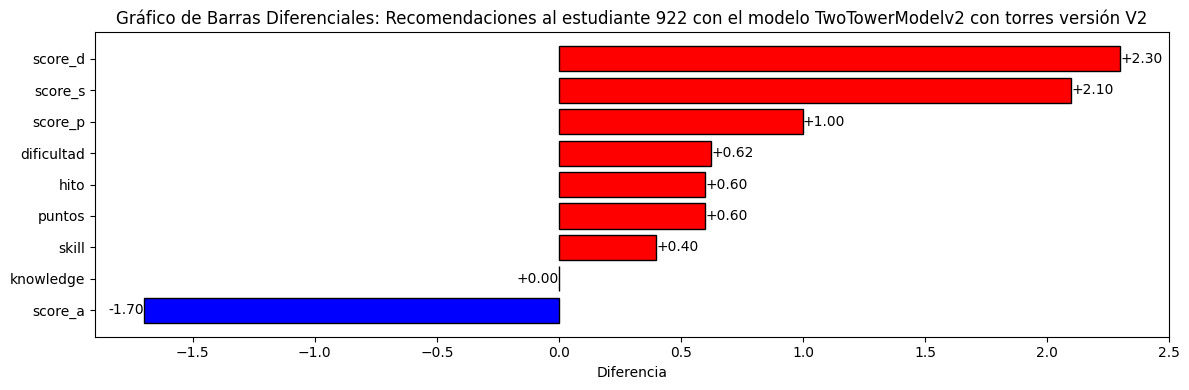

In [56]:
df_resultados_recomendaciones = diferencias_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v3_2,
    usuario_id=usuario_id
)

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title(f'Gráfico de Barras Diferenciales: Recomendaciones al estudiante {usuario_id} con el modelo TwoTowerModelv2 con torres versión V2')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

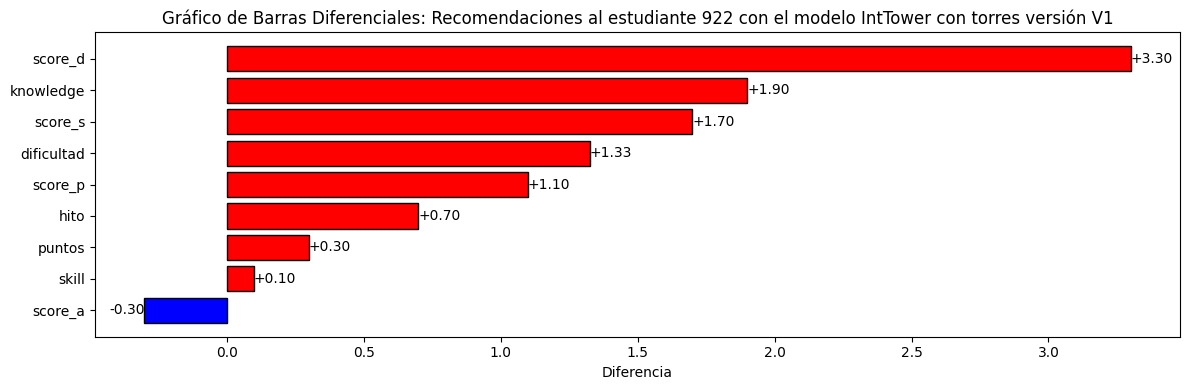

In [57]:
df_resultados_recomendaciones = diferencias_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_interacciones=df_test_interacciones,
    items_recomendados=recommended_items_v4_1,
    usuario_id=usuario_id
)

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title(f'Gráfico de Barras Diferenciales: Recomendaciones al estudiante {usuario_id} con el modelo IntTower con torres versión V1')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

In [58]:

#  ██████╗ ██████╗ ██╗   ██╗███████╗██████╗  █████╗     ██████╗  █████╗ ██████╗  █████╗     ██╗      ██████╗ ███████╗
#  ██╔══██╗██╔══██╗██║   ██║██╔════╝██╔══██╗██╔══██╗    ██╔══██╗██╔══██╗██╔══██╗██╔══██╗    ██║     ██╔═══██╗██╔════╝
#  ██████╔╝██████╔╝██║   ██║█████╗  ██████╔╝███████║    ██████╔╝███████║██████╔╝███████║    ██║     ██║   ██║███████╗
#  ██╔═══╝ ██╔══██╗██║   ██║██╔══╝  ██╔══██╗██╔══██║    ██╔═══╝ ██╔══██║██╔══██╗██╔══██║    ██║     ██║   ██║╚════██║
#  ██║     ██║  ██║╚██████╔╝███████╗██████╔╝██║  ██║    ██║     ██║  ██║██║  ██║██║  ██║    ███████╗╚██████╔╝███████║
#  ╚═╝     ╚═╝  ╚═╝ ╚═════╝ ╚══════╝╚═════╝ ╚═╝  ╚═╝    ╚═╝     ╚═╝  ╚═╝╚═╝  ╚═╝╚═╝  ╚═╝    ╚══════╝ ╚═════╝ ╚══════╝
#                                                                                                                    
#  ██████╗ ███████╗██████╗ ██████╗  ██████╗ ██████╗  █████╗ ██████╗  ██████╗ ███████╗                                
#  ██╔══██╗██╔════╝██╔══██╗██╔══██╗██╔═══██╗██╔══██╗██╔══██╗██╔══██╗██╔═══██╗██╔════╝                                
#  ██████╔╝█████╗  ██████╔╝██████╔╝██║   ██║██████╔╝███████║██║  ██║██║   ██║███████╗                                
#  ██╔══██╗██╔══╝  ██╔═══╝ ██╔══██╗██║   ██║██╔══██╗██╔══██║██║  ██║██║   ██║╚════██║                                
#  ██║  ██║███████╗██║     ██║  ██║╚██████╔╝██████╔╝██║  ██║██████╔╝╚██████╔╝███████║                                
#  ╚═╝  ╚═╝╚══════╝╚═╝     ╚═╝  ╚═╝ ╚═════╝ ╚═════╝ ╚═╝  ╚═╝╚═════╝  ╚═════╝ ╚══════╝                                
#                                                                                                                    

In [59]:
df_reprobados = REPROBADOS[['id_estudiante','programa','exitosos','fallidos','score_a','score_p','score_d','score_s'] + COLUMNAS_EJERCICIOS]

# Crear escalador
scaler_repro = MinMaxScaler()
# Columnas a normalizar
columns_to_normalize = ['exitosos', 'fallidos', 'score_a', 'score_p', 'score_d', 'score_s']
# Ajustar el escalador en el conjunto de entrenamiento
scaler_repro.fit(df_reprobados[columns_to_normalize])  # Ajustar el escalador
# Normalización
df_reprobados[columns_to_normalize] = scaler_repro.transform(df_reprobados[columns_to_normalize])


# Obtener todas las categorías del conjunto de entrenamiento
all_categories_repro = pd.get_dummies(df_reprobados['programa'], drop_first=False).columns
# Generar dummies en cada conjunto y convertirlas a int
train_program_dummies_repro = pd.get_dummies(df_reprobados['programa'], drop_first=False).reindex(columns=all_categories_repro, fill_value=0).astype(int)
# Reemplazar la columna original 'programa' con las nuevas columnas
df_reprobados = df_reprobados.drop(columns=['programa']).join(train_program_dummies_repro)


df_reprobados_interacciones = df_reprobados[['id_estudiante'] + COLUMNAS_EJERCICIOS]
df_reprobados_usuarios = df_reprobados.drop(columns=COLUMNAS_EJERCICIOS)

In [60]:
df_reprobados_usuarios

,id_estudiante,exitosos,fallidos,score_a,score_p,score_d,score_s,BACHILLERATO EN CIENCIAS,INGENIERIA CIVIL INDUSTRIAL,INGENIERIA CIVIL INFORMATICA,INGENIERIA EN COMPUTACION E INFORMATICA,INGENIERIA INDUSTRIAL
234,260,0.00,0.365854,0.333333,0.75,0.50,1.0,0,0,1,0,0
343,381,0.52,0.414634,0.333333,0.50,0.00,0.0,0,0,0,1,0
348,386,0.24,0.414634,1.000000,1.00,1.00,1.0,0,1,0,0,0
427,467,0.36,0.512195,0.000000,0.00,0.25,0.0,0,1,0,0,0
428,468,0.24,0.219512,0.000000,0.00,0.25,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
745,916,0.44,0.097561,0.000000,0.00,0.25,0.0,0,0,0,0,1
746,918,0.40,0.487805,0.000000,0.00,0.25,0.0,0,0,1,0,0
747,919,0.20,0.243902,0.000000,0.00,0.25,0.0,0,0,1,0,0
748,920,0.44,0.097561,0.000000,0.00,0.25,0.0,0,0,0,1,0


In [61]:
repro_recommended_items_v1_1 = {}
repro_recommended_items_v1_2 = {}
repro_recommended_items_v1_3 = {}

repro_recommended_items_v2_1 = {}
repro_recommended_items_v2_2 = {}
repro_recommended_items_v2_3 = {}

repro_recommended_items_v3_1 = {}
repro_recommended_items_v3_2 = {}
repro_recommended_items_v3_3 = {}

repro_recommended_items_v4_1 = {}
repro_recommended_items_v4_2 = {}
repro_recommended_items_v4_3 = {}

repro_recommended_items_v5_1 = {}
repro_recommended_items_v5_2 = {}
repro_recommended_items_v5_3 = {}

# Iterar sobre todos los usuarios en el conjunto de prueba
for user_id in df_reprobados_usuarios['id_estudiante']:
    
    # Obtener las características del usuario actual
    user = df_reprobados_usuarios[df_reprobados_usuarios['id_estudiante'] == user_id]
    interacted = [i for i, interaction in enumerate(df_reprobados_interacciones[df_reprobados_interacciones['id_estudiante'] == user_id].iloc[:, 1:].values.flatten()) if interaction == 1]
    
    # Recomendaciones
    repro_recommendations_v1_1 = recomendador_v1_1.recommend(user, interacted, top_k=10)
    repro_recommendations_v1_2 = recomendador_v1_2.recommend(user, interacted, top_k=10)
    repro_recommendations_v1_3 = recomendador_v1_3.recommend(user, interacted, top_k=10)

    repro_recommendations_v2_1 = recomendador_v2_1.recommend(user, interacted, top_k=10)
    repro_recommendations_v2_2 = recomendador_v2_2.recommend(user, interacted, top_k=10)
    repro_recommendations_v2_3 = recomendador_v2_3.recommend(user, interacted, top_k=10)

    repro_recommendations_v3_1 = recomendador_v3_1.recommend(user, interacted, top_k=10)
    repro_recommendations_v3_2 = recomendador_v3_2.recommend(user, interacted, top_k=10)
    repro_recommendations_v3_3 = recomendador_v3_3.recommend(user, interacted, top_k=10)

    repro_recommendations_v4_1 = recomendador_v4_1.recommend(user, interacted, top_k=10)
    repro_recommendations_v4_2 = recomendador_v4_2.recommend(user, interacted, top_k=10)
    repro_recommendations_v4_3 = recomendador_v4_3.recommend(user, interacted, top_k=10)

    repro_recommendations_v5_1 = recomendador_v5_1.recommend(user, interacted, top_k=10)
    repro_recommendations_v5_2 = recomendador_v5_2.recommend(user, interacted, top_k=10)
    repro_recommendations_v5_3 = recomendador_v5_3.recommend(user, interacted, top_k=10)

    # Items recomendados

    repro_recommended_items_v1_1[user_id] = [rec[0] for rec in repro_recommendations_v1_1] 
    repro_recommended_items_v1_2[user_id] = [rec[0] for rec in repro_recommendations_v1_2]
    repro_recommended_items_v1_3[user_id] = [rec[0] for rec in repro_recommendations_v1_3]

    repro_recommended_items_v2_1[user_id] = [rec[0] for rec in repro_recommendations_v2_1] 
    repro_recommended_items_v2_2[user_id] = [rec[0] for rec in repro_recommendations_v2_2]
    repro_recommended_items_v2_3[user_id] = [rec[0] for rec in repro_recommendations_v2_3]

    repro_recommended_items_v3_1[user_id] = [rec[0] for rec in repro_recommendations_v3_1] 
    repro_recommended_items_v3_2[user_id] = [rec[0] for rec in repro_recommendations_v3_2]
    repro_recommended_items_v3_3[user_id] = [rec[0] for rec in repro_recommendations_v3_3]

    repro_recommended_items_v4_1[user_id] = [rec[0] for rec in repro_recommendations_v4_1] 
    repro_recommended_items_v4_2[user_id] = [rec[0] for rec in repro_recommendations_v4_2]
    repro_recommended_items_v4_3[user_id] = [rec[0] for rec in repro_recommendations_v4_3]

    repro_recommended_items_v5_1[user_id] = [rec[0] for rec in repro_recommendations_v5_1] 
    repro_recommended_items_v5_2[user_id] = [rec[0] for rec in repro_recommendations_v5_2]
    repro_recommended_items_v5_3[user_id] = [rec[0] for rec in repro_recommendations_v5_3]

In [62]:
recomendador_v5_1.evaluate_relevance(
    recommended_items=repro_recommended_items_v5_1,
    popularity_bias=popularidad_items
)

recomendador_v5_2.evaluate_relevance(
    recommended_items=repro_recommended_items_v5_2,
    popularity_bias=popularidad_items
)

recomendador_v5_3.evaluate_relevance(
    recommended_items=repro_recommended_items_v5_3,
    popularity_bias=popularidad_items
)

Convergencia: 0.3585, Novedad: 12.4719, Sesgo de Popularidad: 5.2160
Convergencia: 0.6415, Novedad: 9.9488, Sesgo de Popularidad: 66.6445
Convergencia: 0.5660, Novedad: -6.2482, Sesgo de Popularidad: 379.6890


In [63]:
repro_usuario_id = df_reprobados['id_estudiante'].sample(1, random_state=VAR_SEED).iloc[0]
print(f'Estudiante: {usuario_id}')

Estudiante: 922


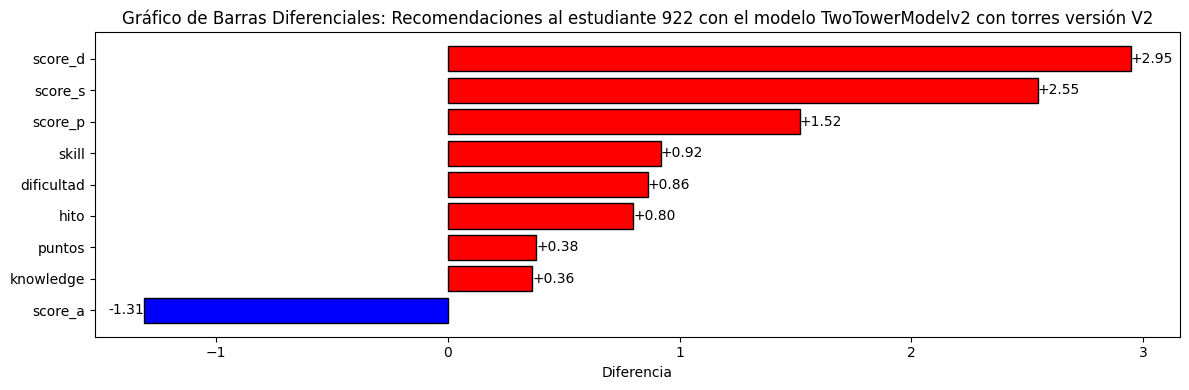

In [64]:
df_resultados_recomendaciones = diferencias_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_interacciones=df_reprobados_interacciones,
    items_recomendados=repro_recommended_items_v4_2,
    usuario_id=repro_usuario_id
)

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title(f'Gráfico de Barras Diferenciales: Recomendaciones al estudiante {usuario_id} con el modelo TwoTowerModelv2 con torres versión V2')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

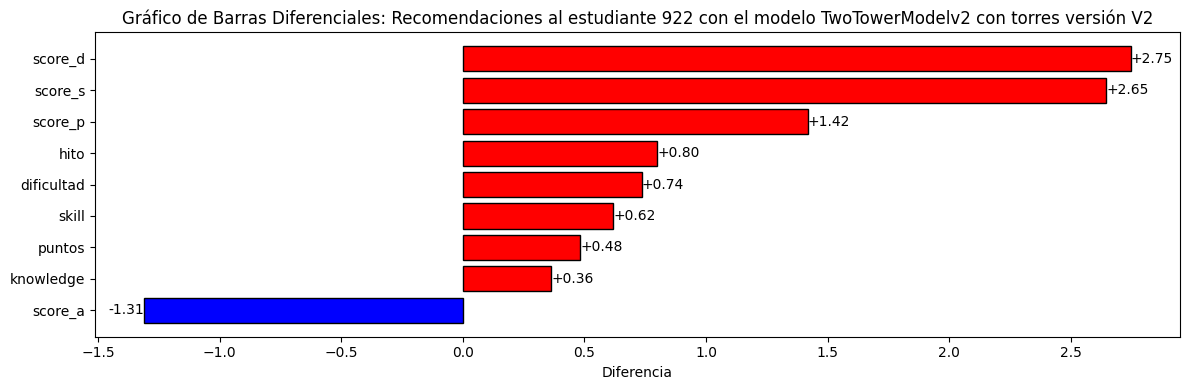

In [65]:
df_resultados_recomendaciones = diferencias_recomendaciones(
    columnas=['hito', 'skill', 'knowledge', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s'],
    df_ejercicios=EJERCICIOS,
    df_interacciones=df_reprobados_interacciones,
    items_recomendados=repro_recommended_items_v5_3,
    usuario_id=repro_usuario_id
)

variables = df_resultados_recomendaciones.columns.to_list()
diferencias = df_resultados_recomendaciones.mean().values

orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

fig, ax = plt.subplots(figsize=(12, 4))
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title(f'Gráfico de Barras Diferenciales: Recomendaciones al estudiante {usuario_id} con el modelo TwoTowerModelv2 con torres versión V2')

for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()